In [1]:
# %load_ext autoreload
# %autoreload 2
# from utils import *
# from Network import *
# basic packages
import numpy as np
import glob
# import h5py
import math
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats
import os
import copy
import time
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision.transforms import ToTensor
#from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm.autonotebook import tqdm
import sys
sys.path.append('/scratch/xc1490/projects/tmp/python_packages')
import wandb
wandb.__version__
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/ext3/miniconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
use_wandb = False
if use_wandb:
    os.environ['WANDB_DISABLE_SERVICE'] = 'True'

In [3]:
# config
FRAME_RATE = 60 # 60 frames/sec
MAX_HISTORY_TIME = 10
MAX_PREDICTION_TIME = 10
HISTORY_TIME = 2
PREDICTION_TIME = 2
HISTORY_LENGTH = HISTORY_TIME*FRAME_RATE
PREDICTION_LENGTH = PREDICTION_TIME*FRAME_RATE
MAX_HISTORY_LENGTH = MAX_HISTORY_TIME*FRAME_RATE
MAX_PREDICTION_LENGTH = MAX_PREDICTION_TIME*FRAME_RATE
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
FEATURE_SIZE = 9
BATCH_SIZE = 16

cuda


In [4]:
class FoVDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = torch.tensor(self.x_data[idx])
        y = torch.tensor(self.y_data[idx])
        return x,y
# data
x_train = np.loadtxt('processed_data/x_train.csv', dtype='float32', delimiter=',').reshape((-1,MAX_HISTORY_LENGTH,FEATURE_SIZE))[:,:HISTORY_LENGTH,:]
y_train = np.loadtxt('processed_data/y_train.csv', dtype='float32', delimiter=',').reshape((-1,MAX_PREDICTION_LENGTH,FEATURE_SIZE))[:,:PREDICTION_LENGTH,:]
x_val = np.loadtxt('processed_data/x_val.csv', dtype='float32', delimiter=',').reshape((-1,MAX_HISTORY_LENGTH,FEATURE_SIZE))[:,:HISTORY_LENGTH,:]
y_val = np.loadtxt('processed_data/x_val.csv', dtype='float32', delimiter=',').reshape((-1,MAX_PREDICTION_LENGTH,FEATURE_SIZE))[:,:PREDICTION_LENGTH,:]
x_test = np.loadtxt('processed_data/x_test.csv', dtype='float32', delimiter=',').reshape((-1,MAX_HISTORY_LENGTH,FEATURE_SIZE))[:,:HISTORY_LENGTH,:]
y_test = np.loadtxt('processed_data/y_test.csv', dtype='float32', delimiter=',').reshape((-1,MAX_PREDICTION_LENGTH,FEATURE_SIZE))[:,:PREDICTION_LENGTH,:]
mean_std = np.loadtxt('processed_data/xyz_mean_std.csv', dtype='float32', delimiter=',').reshape((3, -1))
train_data = FoVDataset(x_train, y_train)
val_data = FoVDataset(x_val, y_val)
test_data = FoVDataset(x_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
import torch
from performer_pytorch import Performer

model = Performer(
    dim = 9,
    depth = 3,
    heads = 3,
    causal = True
).to(device=DEVICE)

x = torch.randn(16, 120, 9)
output = model(x.to(device=DEVICE)) 
output.shape

/ext3/miniconda3/lib/python3.7/site-packages/performer_pytorch/performer_pytorch.py:82: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809535/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2491.)
  q, r = torch.qr(unstructured_block.cpu(), some = True)


unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version
unable to import cuda code for auto-regressive Performer. will default to the memory inefficient non-cuda version


torch.Size([16, 120, 9])

In [6]:
# should fit in ~ 5gb - 8k embeddings

import torch
from reformer_pytorch import Reformer

model = Reformer(
    dim = 9,
    depth = 4,
    heads = 3,
    lsh_dropout = 0.1,
    bucket_size = 60,
    causal = True
).to(device=DEVICE).requires_grad_(True)

x = torch.randn(16, 120, 9)
output = model(x.to(device=DEVICE)) 
output.shape

torch.Size([16, 120, 9])

In [7]:
import torch
from iTransformer import iTransformer
from TimesNet import TimesNet
from PatchTST import PatchTST
device = "cuda" if torch.cuda.is_available() else "cpu"
model = iTransformer(seq_len = 120, pred_len = 120, enc_in = 9, d_model = 9,\
                    norm = False).float().to(device)

In [8]:
model = TimesNet(seq_len = 120, pred_len = 120, enc_in = 9, d_model =9, c_out = 9, \
                    norm = False).float().to(device)

In [9]:
model(x.to(device=DEVICE), debug=True).shape, x.shape

x_enc, x_mark_enc torch.Size([16, 120, 9]) None
embed torch.Size([16, 120, 9])
predict_linear torch.Size([16, 120, 9])
encoder torch.Size([16, 120, 9])
projection torch.Size([16, 120, 9])


(torch.Size([16, 120, 9]), torch.Size([16, 120, 9]))

In [10]:
model.__class__.__name__

'TimesNet'

In [11]:
#training hyperparams
enc_seq_len = HISTORY_LENGTH
dec_seq_len = PREDICTION_LENGTH
output_sequence_length = PREDICTION_LENGTH

n_heads = 4
head_dim = 32 # dimension of each head, not total
dim_val = 16#n_heads*head_dim # embedding dimension, all heads together
lr = 0.05
tf_rate = 0.5
epochs = 400
n_decoder_layers = 3
n_encoder_layers = 3
batch_size = BATCH_SIZE
n_batches = len(train_dataloader)

#init network and optimizer
#model = Transformer(dim_val, head_dim, FEATURE_SIZE, dec_seq_len, output_sequence_length, n_decoder_layers, n_encoder_layers, n_heads, device=DEVICE).to(device=DEVICE)


model

TimesNet(
  (model): ModuleList(
    (0): TimesBlock(
      (conv): Sequential(
        (0): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(9, 256, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(9, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(9, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (3): Conv2d(9, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
            (4): Conv2d(9, 256, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
            (5): Conv2d(9, 256, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
          )
        )
        (1): GELU(approximate=none)
        (2): Inception_Block_V1(
          (kernels): ModuleList(
            (0): Conv2d(256, 9, kernel_size=(1, 1), stride=(1, 1))
            (1): Conv2d(256, 9, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): Conv2d(256, 9, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
            (

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
#keep track of loss for graph
train_losses = []
val_losses = []
test_losses = []
sep_train_losses = []
sep_val_losses = []
sep_test_losses = []
train_pearsonr_arr = []
val_pearsonr_arr = []
test_pearsonr_arr = []

In [13]:
def my_loss(output, target):
    # compute loss for each feature
    # output/target: [N, seq_len, 9]
    # change sin cos back to angle ?
    output_rx = torch.atan2(output[:,:,3], output[:,:,4]).unsqueeze(2)
    output_ry = torch.atan2(output[:,:,5], output[:,:,6]).unsqueeze(2)
    output_rz = torch.atan2(output[:,:,7], output[:,:,8]).unsqueeze(2)
    target_rx = torch.atan2(target[:,:,3], target[:,:,4]).unsqueeze(2)
    target_ry = torch.atan2(target[:,:,5], target[:,:,6]).unsqueeze(2)
    target_rz = torch.atan2(target[:,:,7], target[:,:,8]).unsqueeze(2)
    output = torch.cat((output,output_rx,output_ry,output_rz),-1)
    target = torch.cat((target,target_rx,target_ry,target_rz),-1)
    
    loss = torch.mean((output - target) ** 2, [0,1])
    pearsonr = stats.pearsonr(output.detach().cpu().flatten(), target.detach().cpu().flatten())
    return loss, pearsonr

In [14]:
loss_names = ['x loss','y loss','z loss','r_sin loss','r_cos loss','p_sin loss','p_cos loss','y_sin loss',\
'y_cos loss','rx loss','ry loss','rz loss']
def train(model: nn.Module, data_loader, optimizer, scaler, writer, step) -> None:
    progress_bar = tqdm(data_loader)
    model.train() # turn on train mode
    total_loss = 0.
    start_time = time.time()
    num_batches = len(data_loader)
    log_interval = num_batches // 5
    return_loss = 0.
    sep_return_loss = np.zeros((1,12))
    loss_dict_train = {}
#     total_sep_loss = np.zeros((1,6))
    for batch_idx, (data, targets) in enumerate(progress_bar):
#         print("batch index: ", batch_idx)
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)
        #print ('data, targets',data.shape, targets.shape)
        # with torch.cuda.amp.autocast():
        output = model(data)
        optimizer.zero_grad()
        # loss = criterion(output, targets)
        sep_loss, train_pearsonr = my_loss(output, targets)
#         print("sep_loss shape: ", sep_loss.unsqueeze(0).shape)
        # scaler.scale(loss).backward()
        loss = torch.sum(sep_loss[:9])
        if model.__class__.__name__ =='Reformer':
            loss.requires_grad_(True)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        # scaler.step(optimizer)
        optimizer.step()
        # scaler.update()
        #writer.add_scalar("Training Loss", loss, global_step=step)
        step += 1
        total_loss += loss.item()
        return_loss += loss.item()
        sep_return_loss += sep_loss.detach().cpu().numpy()
        progress_bar.set_postfix_str(f"training loss={loss.item():.4e}|avg training loss={total_loss/(batch_idx+1):.4e}")
        loss_dict_train['training loss'] = loss.item()
        for name_count, loss_name in enumerate(loss_names):
            loss_dict_train[loss_name] = sep_loss[name_count]
#         loss_dict_train['x loss'] = sep_loss[0]
#         loss_dict_train['y loss'] = sep_loss[1]
#         loss_dict_train['z loss'] = sep_loss[2]
#         loss_dict_train['r_sin loss'] = sep_loss[3]
#         loss_dict_train['r_cos loss'] = sep_loss[4]
#         loss_dict_train['p_sin loss'] = sep_loss[5]
#         loss_dict_train['p_cos loss'] = sep_loss[6]      
#         loss_dict_train['y_sin loss'] = sep_loss[7]      
#         loss_dict_train['y_cos loss'] = sep_loss[8]
#         loss_dict_train['rx loss'] = sep_loss[9]    
#         loss_dict_train['ry loss'] = sep_loss[10]
#         loss_dict_train['rz loss'] = sep_loss[11]
        
        loss_dict_train['avg training loss'] = total_loss/(batch_idx+1)
        loss_dict_train['train pearsonr'] = train_pearsonr
        if use_wandb:
            wandb.log(loss_dict_train) 
        if batch_idx % log_interval == 0 and batch_idx > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            print(f'| epoch {epoch:3d} | {batch_idx:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.5f} | ms/batch {ms_per_batch:5.5f} | '
                  f'loss {cur_loss:5.5f}')
            total_loss = 0
            start_time = time.time()
    return return_loss/(batch_idx+1), sep_return_loss/(batch_idx+1), train_pearsonr

def validate(model: nn.Module, dataloader: DataLoader, plot_flag = False) -> float:
    model.eval()
    total_loss = 0.
    sep_total_loss = np.zeros((1,12))
    loss_dict_valid = {}
    iter_count = 0
    with torch.no_grad():
        for (data, targets) in dataloader:
            data = data.to(device=DEVICE) # [N, seq_len, feature_size]
            targets = targets.to(device=DEVICE) # [N, seq_len, feature_size]
            output = model(data)
            if plot_flag and iter_count == 0:
                print ('validation prediction')
                fig, ax = plt.subplots(3,3,figsize=(30,12))
                for i in range(3):
                    for j in range(3):
                        ax[i,j].plot(targets.detach().cpu().numpy()[0,:,i*3+j])
                        ax[i,j].plot(output.detach().cpu().numpy()[0,:,i*3+j])
                        ax[i,j].legend(['target','output'])
                        ax[i,j].set_title('validation prediction {}'.format(i*3+j))
                plt.show()
                #import pdb;pdb.set_trace()
                #print("output: ", output)
                if use_wandb:
                    wandb.log({"validation plot": fig})
            sep_valid_loss, valid_pearsonr = my_loss(output, targets)
            total_loss += torch.sum(sep_valid_loss)
            sep_total_loss += sep_valid_loss.detach().cpu().numpy()
            #import pdb;pdb.set_trace()
            for name_count, loss_name in enumerate(loss_names):
                loss_dict_valid[loss_name] = sep_valid_loss[name_count]
            #loss_dict_valid['valid loss'] = sep_valid_loss
            loss_dict_valid['valid pearsonr'] = valid_pearsonr[0]
            iter_count += 1
            if use_wandb:
                wandb.log(loss_dict_valid) 
    return total_loss/(len(dataloader) - 1), sep_total_loss/(len(dataloader) - 1), valid_pearsonr
    

# def inference(model: nn.Module, dataloader: DataLoader) -> float:
#     model.eval()  # turn on evaluation mode
#     total_loss = 0.
#     o = []
#     loss_dict_test = {}
#     with torch.no_grad():
#         for (data, targets) in dataloader:
#             data = data.to(device=DEVICE) # [N, seq_len, feature_size]
#             targets = targets.to(device=DEVICE) # [N, seq_len, feature_size]
#             N, seq_len, feature_size = targets.shape
#             dec_input = torch.zeros(targets.shape)
#             for i in range(seq_len):
#                 if i == 0:
#                     dec_input = data
#                     output = model(data, dec_input)
#                     o = output
#                 else:
#                     dec_input[:,:seq_len-i,:] = data[:,i:,:]
#                     dec_input[:,seq_len-i:,:] = o
#                     output = model(data, dec_input)
#                     o = torch.hstack(o, output[:,-1,:])
#             test_loss = my_loss(o, targets).item()
#             total_loss += test_loss
#             loss_dict_test['test loss'] = test_loss
#             wandb.log(loss_dict_test) 
#             # print("val loss: ", total_loss)
#             # data = data.permute(1, 0, 2) #.detach().cpu().numpy()
#             # output = output.permute(1, 0, 2) #.detach().cpu().numpy()
#             # print("output2: ", output[0][0])
#     return total_loss / (len(dataloader) - 1)

In [15]:
if use_wandb:
    wandb.init(
        project="Transformer_Enc_MLP",
        # track hyperparameters and run metadata
        #config=vars(args)
        config={
            "epochs": epochs,
            "batch_size": batch_size,
            "history_time": HISTORY_TIME,
            "prediction_time": PREDICTION_TIME,
            "learning_rate": lr,
            "dim_val": dim_val,
            "decoder": "MLP"
        }
    )

In [16]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch #1


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   1 |    31/  158 batches | lr 0.05000 | ms/batch 53.48580 | loss 4.45141
| epoch   1 |    62/  158 batches | lr 0.05000 | ms/batch 46.05531 | loss 3.77207
| epoch   1 |    93/  158 batches | lr 0.05000 | ms/batch 45.19018 | loss 3.85447
| epoch   1 |   124/  158 batches | lr 0.05000 | ms/batch 44.58963 | loss 3.72472
| epoch   1 |   155/  158 batches | lr 0.05000 | ms/batch 45.63310 | loss 3.48852
validation prediction


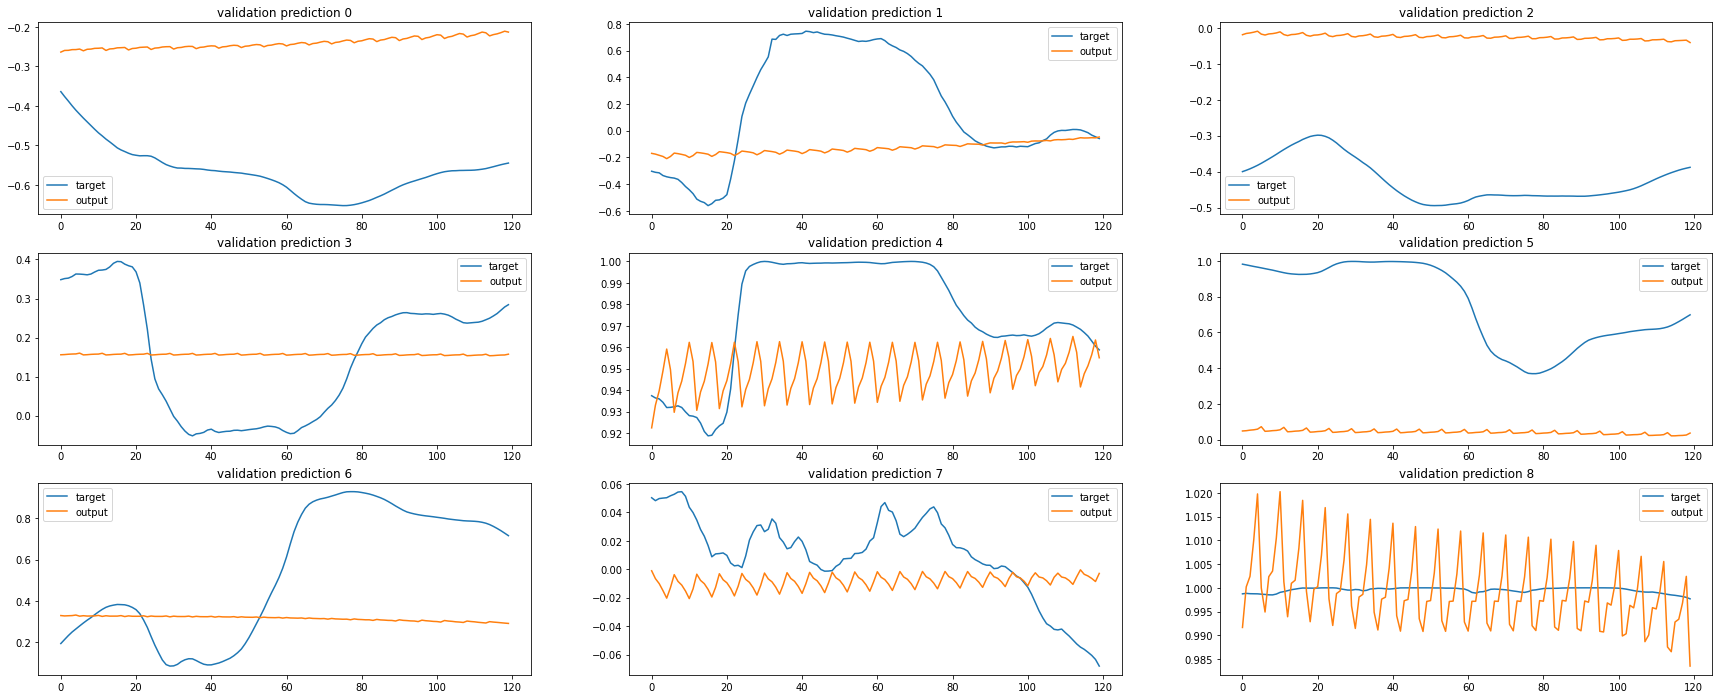

-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  8.76s | valid loss 8.6908 | mean loss   3.8199
-----------------------------------------------------------------------------------------


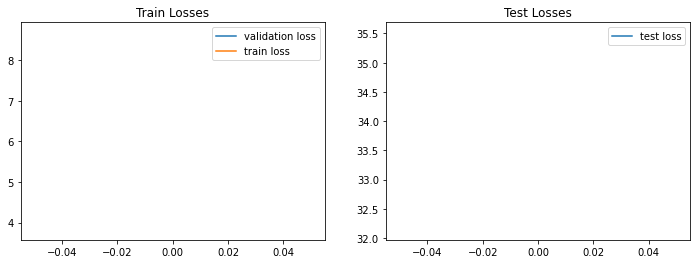

Epoch #2


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   2 |    31/  158 batches | lr 0.04750 | ms/batch 46.85524 | loss 3.58127
| epoch   2 |    62/  158 batches | lr 0.04750 | ms/batch 45.40224 | loss 3.47015
| epoch   2 |    93/  158 batches | lr 0.04750 | ms/batch 44.77971 | loss 3.54700
| epoch   2 |   124/  158 batches | lr 0.04750 | ms/batch 44.60435 | loss 3.40501
| epoch   2 |   155/  158 batches | lr 0.04750 | ms/batch 45.56317 | loss 3.15097
-----------------------------------------------------------------------------------------
| end of epoch   2 | time:  7.51s | valid loss 8.0131 | mean loss   3.6131
-----------------------------------------------------------------------------------------
Epoch #3


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   3 |    31/  158 batches | lr 0.04512 | ms/batch 46.27914 | loss 3.13425
| epoch   3 |    62/  158 batches | lr 0.04512 | ms/batch 44.86254 | loss 3.09446
| epoch   3 |    93/  158 batches | lr 0.04512 | ms/batch 44.63934 | loss 3.11548
| epoch   3 |   124/  158 batches | lr 0.04512 | ms/batch 46.09610 | loss 2.97434
| epoch   3 |   155/  158 batches | lr 0.04512 | ms/batch 46.23370 | loss 3.05604
-----------------------------------------------------------------------------------------
| end of epoch   3 | time:  7.55s | valid loss 6.0618 | mean loss   3.4267
-----------------------------------------------------------------------------------------
Epoch #4


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   4 |    31/  158 batches | lr 0.04287 | ms/batch 47.16774 | loss 3.05288
| epoch   4 |    62/  158 batches | lr 0.04287 | ms/batch 45.78577 | loss 3.00673
| epoch   4 |    93/  158 batches | lr 0.04287 | ms/batch 44.36764 | loss 2.93608
| epoch   4 |   124/  158 batches | lr 0.04287 | ms/batch 44.59223 | loss 2.99055
| epoch   4 |   155/  158 batches | lr 0.04287 | ms/batch 44.83406 | loss 2.89791
-----------------------------------------------------------------------------------------
| end of epoch   4 | time:  7.50s | valid loss 7.3094 | mean loss   3.3091
-----------------------------------------------------------------------------------------
Epoch #5


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   5 |    31/  158 batches | lr 0.04073 | ms/batch 47.21994 | loss 2.87653
| epoch   5 |    62/  158 batches | lr 0.04073 | ms/batch 44.98898 | loss 2.82066
| epoch   5 |    93/  158 batches | lr 0.04073 | ms/batch 45.00461 | loss 2.93979
| epoch   5 |   124/  158 batches | lr 0.04073 | ms/batch 45.95890 | loss 3.07967
| epoch   5 |   155/  158 batches | lr 0.04073 | ms/batch 44.97503 | loss 2.85894
-----------------------------------------------------------------------------------------
| end of epoch   5 | time:  7.55s | valid loss 7.0216 | mean loss   3.2263
-----------------------------------------------------------------------------------------
Epoch #6


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   6 |    31/  158 batches | lr 0.03869 | ms/batch 46.34454 | loss 3.06856
| epoch   6 |    62/  158 batches | lr 0.03869 | ms/batch 45.89188 | loss 2.88733
| epoch   6 |    93/  158 batches | lr 0.03869 | ms/batch 45.06445 | loss 2.75409
| epoch   6 |   124/  158 batches | lr 0.03869 | ms/batch 44.78866 | loss 2.73123
| epoch   6 |   155/  158 batches | lr 0.03869 | ms/batch 45.51231 | loss 2.77082
validation prediction


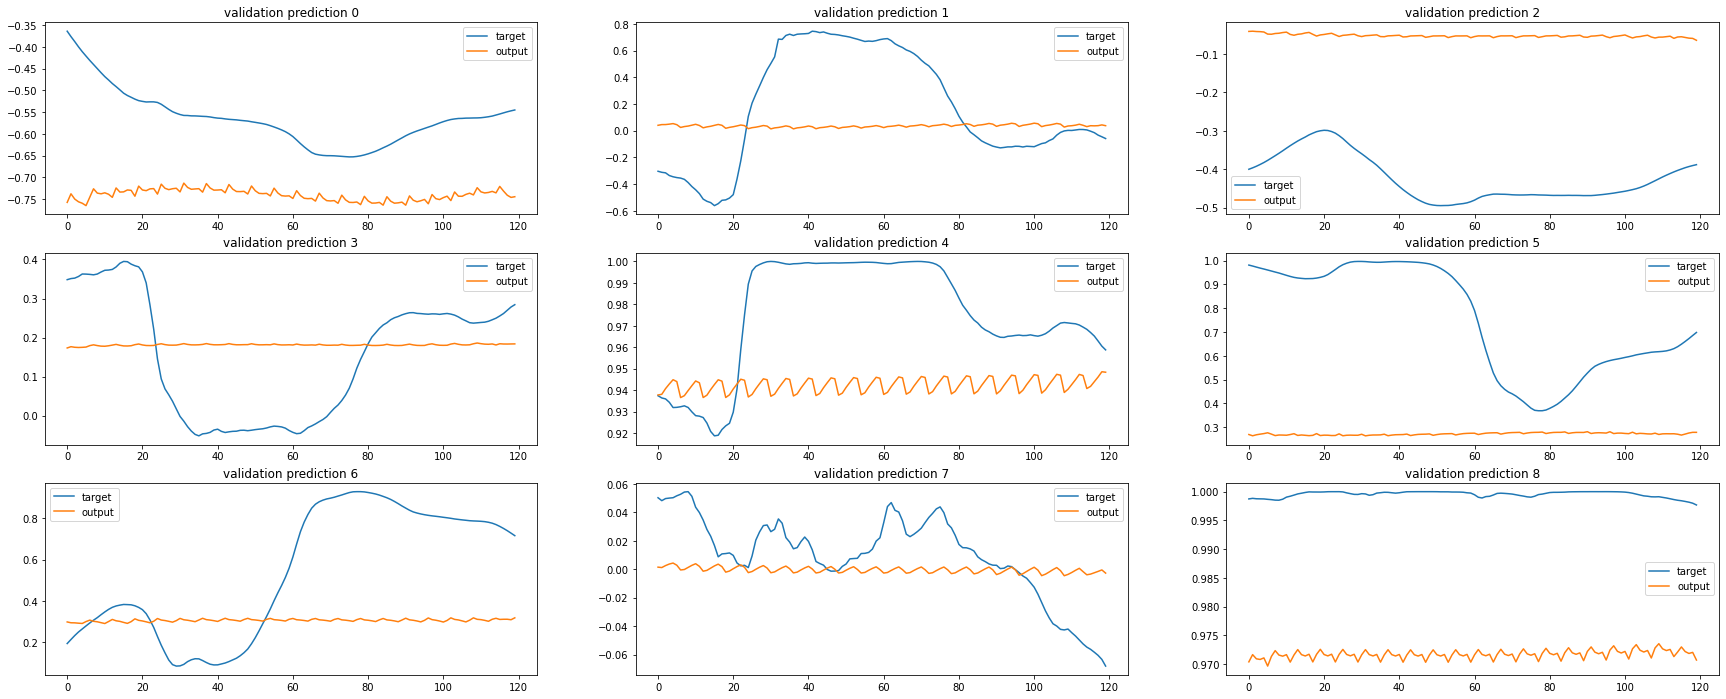

-----------------------------------------------------------------------------------------
| end of epoch   6 | time:  8.63s | valid loss 6.1344 | mean loss   3.1603
-----------------------------------------------------------------------------------------


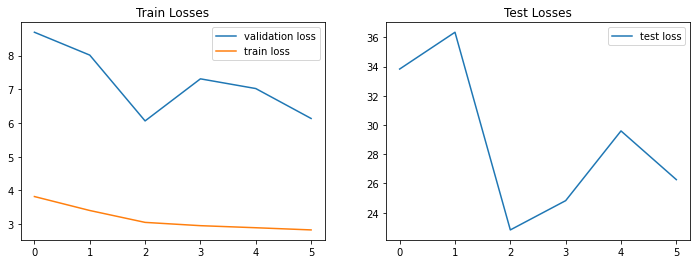

Epoch #7


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   7 |    31/  158 batches | lr 0.03675 | ms/batch 46.16064 | loss 2.96135
| epoch   7 |    62/  158 batches | lr 0.03675 | ms/batch 45.07081 | loss 2.71848
| epoch   7 |    93/  158 batches | lr 0.03675 | ms/batch 46.20910 | loss 2.76059
| epoch   7 |   124/  158 batches | lr 0.03675 | ms/batch 45.09441 | loss 2.64259
| epoch   7 |   155/  158 batches | lr 0.03675 | ms/batch 45.54998 | loss 2.58711
-----------------------------------------------------------------------------------------
| end of epoch   7 | time:  7.54s | valid loss 8.1857 | mean loss   3.0979
-----------------------------------------------------------------------------------------
Epoch #8


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   8 |    31/  158 batches | lr 0.03492 | ms/batch 46.34048 | loss 2.78842
| epoch   8 |    62/  158 batches | lr 0.03492 | ms/batch 46.11518 | loss 2.68813
| epoch   8 |    93/  158 batches | lr 0.03492 | ms/batch 45.73244 | loss 2.60674
| epoch   8 |   124/  158 batches | lr 0.03492 | ms/batch 46.12782 | loss 2.53503
| epoch   8 |   155/  158 batches | lr 0.03492 | ms/batch 45.53822 | loss 2.53790
-----------------------------------------------------------------------------------------
| end of epoch   8 | time:  7.60s | valid loss 6.6760 | mean loss   3.0368
-----------------------------------------------------------------------------------------
Epoch #9


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch   9 |    31/  158 batches | lr 0.03317 | ms/batch 46.78023 | loss 2.57687
| epoch   9 |    62/  158 batches | lr 0.03317 | ms/batch 46.62967 | loss 2.57855
| epoch   9 |    93/  158 batches | lr 0.03317 | ms/batch 44.58674 | loss 2.52759
| epoch   9 |   124/  158 batches | lr 0.03317 | ms/batch 44.68426 | loss 2.40686
| epoch   9 |   155/  158 batches | lr 0.03317 | ms/batch 44.54666 | loss 2.45711
-----------------------------------------------------------------------------------------
| end of epoch   9 | time:  7.53s | valid loss 7.8280 | mean loss   2.9763
-----------------------------------------------------------------------------------------
Epoch #10


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  10 |    31/  158 batches | lr 0.03151 | ms/batch 46.06543 | loss 2.60027
| epoch  10 |    62/  158 batches | lr 0.03151 | ms/batch 45.57506 | loss 2.44269
| epoch  10 |    93/  158 batches | lr 0.03151 | ms/batch 45.11565 | loss 2.32773
| epoch  10 |   124/  158 batches | lr 0.03151 | ms/batch 45.27037 | loss 2.35642
| epoch  10 |   155/  158 batches | lr 0.03151 | ms/batch 45.51085 | loss 2.33522
-----------------------------------------------------------------------------------------
| end of epoch  10 | time:  7.53s | valid loss 6.9346 | mean loss   2.9179
-----------------------------------------------------------------------------------------
Epoch #11


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  11 |    31/  158 batches | lr 0.02994 | ms/batch 47.64219 | loss 2.33300
| epoch  11 |    62/  158 batches | lr 0.02994 | ms/batch 44.75455 | loss 2.28852
| epoch  11 |    93/  158 batches | lr 0.02994 | ms/batch 45.40785 | loss 2.32087
| epoch  11 |   124/  158 batches | lr 0.02994 | ms/batch 45.56591 | loss 2.20656
| epoch  11 |   155/  158 batches | lr 0.02994 | ms/batch 45.40606 | loss 2.20399
validation prediction


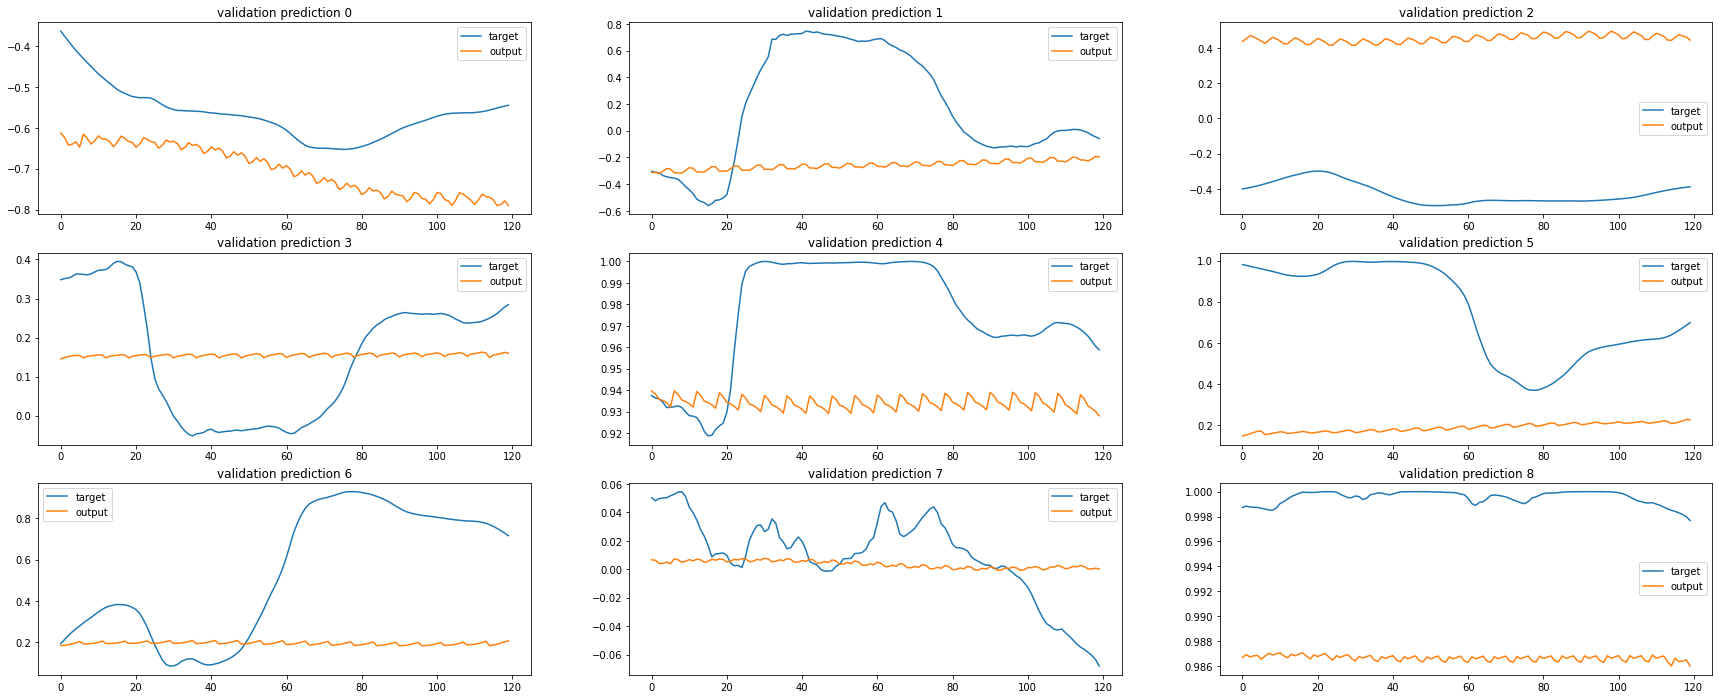

-----------------------------------------------------------------------------------------
| end of epoch  11 | time:  8.53s | valid loss 7.2121 | mean loss   2.8575
-----------------------------------------------------------------------------------------


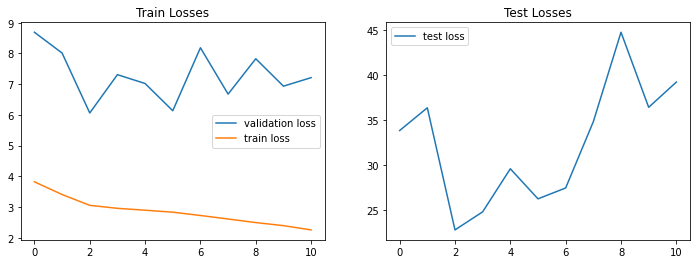

Epoch #12


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  12 |    31/  158 batches | lr 0.02844 | ms/batch 47.35301 | loss 2.42889
| epoch  12 |    62/  158 batches | lr 0.02844 | ms/batch 46.73050 | loss 2.36024
| epoch  12 |    93/  158 batches | lr 0.02844 | ms/batch 45.63811 | loss 2.36258
| epoch  12 |   124/  158 batches | lr 0.02844 | ms/batch 45.29841 | loss 2.23957
| epoch  12 |   155/  158 batches | lr 0.02844 | ms/batch 46.00989 | loss 2.31694
-----------------------------------------------------------------------------------------
| end of epoch  12 | time:  7.67s | valid loss 7.1166 | mean loss   2.8135
-----------------------------------------------------------------------------------------
Epoch #13


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  13 |    31/  158 batches | lr 0.02702 | ms/batch 47.82504 | loss 2.31336
| epoch  13 |    62/  158 batches | lr 0.02702 | ms/batch 46.09698 | loss 2.23995
| epoch  13 |    93/  158 batches | lr 0.02702 | ms/batch 46.55286 | loss 2.12838
| epoch  13 |   124/  158 batches | lr 0.02702 | ms/batch 45.46502 | loss 2.16948
| epoch  13 |   155/  158 batches | lr 0.02702 | ms/batch 45.52787 | loss 2.16824
-----------------------------------------------------------------------------------------
| end of epoch  13 | time:  7.70s | valid loss 7.8533 | mean loss   2.7654
-----------------------------------------------------------------------------------------
Epoch #14


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  14 |    31/  158 batches | lr 0.02567 | ms/batch 48.16121 | loss 2.26865
| epoch  14 |    62/  158 batches | lr 0.02567 | ms/batch 45.90208 | loss 2.05007
| epoch  14 |    93/  158 batches | lr 0.02567 | ms/batch 45.41371 | loss 1.96844
| epoch  14 |   124/  158 batches | lr 0.02567 | ms/batch 45.74004 | loss 1.95566
| epoch  14 |   155/  158 batches | lr 0.02567 | ms/batch 45.79547 | loss 2.12785
-----------------------------------------------------------------------------------------
| end of epoch  14 | time:  7.68s | valid loss 7.5633 | mean loss   2.7151
-----------------------------------------------------------------------------------------
Epoch #15


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  15 |    31/  158 batches | lr 0.02438 | ms/batch 48.01448 | loss 2.02577
| epoch  15 |    62/  158 batches | lr 0.02438 | ms/batch 45.66135 | loss 1.81929
| epoch  15 |    93/  158 batches | lr 0.02438 | ms/batch 45.68915 | loss 1.89079
| epoch  15 |   124/  158 batches | lr 0.02438 | ms/batch 45.22684 | loss 1.79600
| epoch  15 |   155/  158 batches | lr 0.02438 | ms/batch 46.44840 | loss 1.89678
-----------------------------------------------------------------------------------------
| end of epoch  15 | time:  7.69s | valid loss 8.3861 | mean loss   2.6590
-----------------------------------------------------------------------------------------
Epoch #16


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  16 |    31/  158 batches | lr 0.02316 | ms/batch 47.98481 | loss 1.89529
| epoch  16 |    62/  158 batches | lr 0.02316 | ms/batch 46.67601 | loss 1.64374
| epoch  16 |    93/  158 batches | lr 0.02316 | ms/batch 46.04356 | loss 1.88126
| epoch  16 |   124/  158 batches | lr 0.02316 | ms/batch 45.25921 | loss 1.64162
| epoch  16 |   155/  158 batches | lr 0.02316 | ms/batch 46.27651 | loss 1.66084
validation prediction


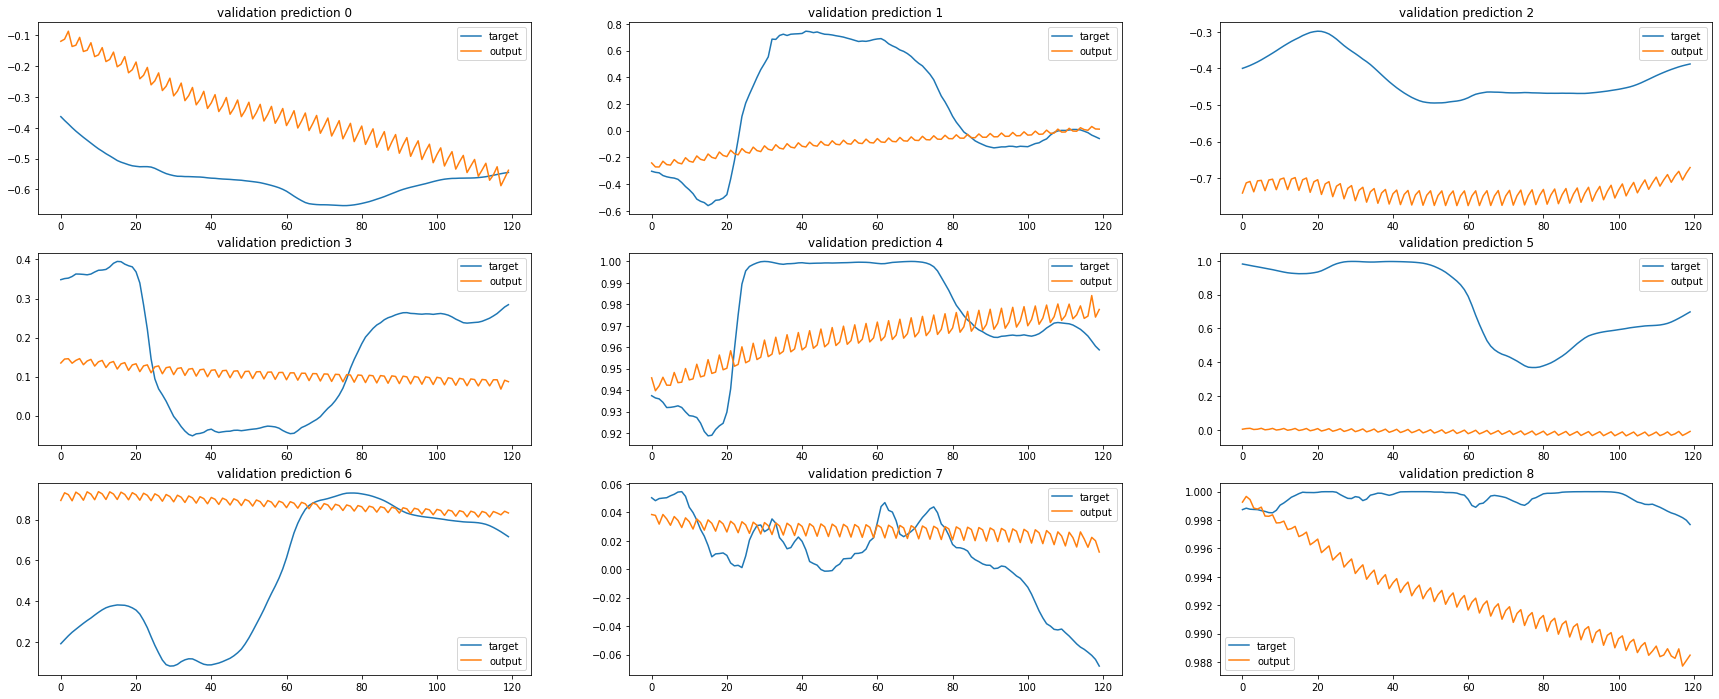

-----------------------------------------------------------------------------------------
| end of epoch  16 | time:  8.80s | valid loss 8.5964 | mean loss   2.6014
-----------------------------------------------------------------------------------------


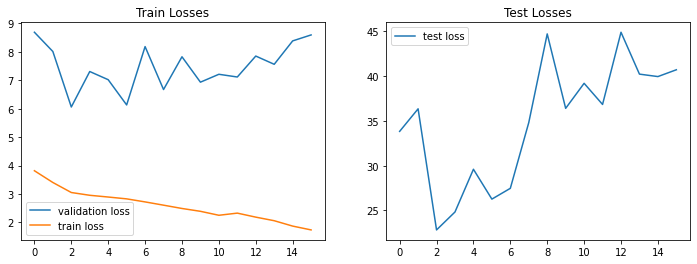

Epoch #17


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  17 |    31/  158 batches | lr 0.02201 | ms/batch 47.51980 | loss 1.62875
| epoch  17 |    62/  158 batches | lr 0.02201 | ms/batch 45.49979 | loss 1.64672
| epoch  17 |    93/  158 batches | lr 0.02201 | ms/batch 46.02902 | loss 1.52881
| epoch  17 |   124/  158 batches | lr 0.02201 | ms/batch 47.04606 | loss 1.60544
| epoch  17 |   155/  158 batches | lr 0.02201 | ms/batch 46.57122 | loss 1.61480
-----------------------------------------------------------------------------------------
| end of epoch  17 | time:  7.71s | valid loss 11.0356 | mean loss   2.5424
-----------------------------------------------------------------------------------------
Epoch #18


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  18 |    31/  158 batches | lr 0.02091 | ms/batch 47.16802 | loss 1.49122
| epoch  18 |    62/  158 batches | lr 0.02091 | ms/batch 45.69242 | loss 1.52342
| epoch  18 |    93/  158 batches | lr 0.02091 | ms/batch 45.42256 | loss 1.50871
| epoch  18 |   124/  158 batches | lr 0.02091 | ms/batch 45.56720 | loss 1.52781
| epoch  18 |   155/  158 batches | lr 0.02091 | ms/batch 45.47201 | loss 1.38097
-----------------------------------------------------------------------------------------
| end of epoch  18 | time:  7.62s | valid loss 10.0422 | mean loss   2.4831
-----------------------------------------------------------------------------------------
Epoch #19


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  19 |    31/  158 batches | lr 0.01986 | ms/batch 47.78660 | loss 1.39624
| epoch  19 |    62/  158 batches | lr 0.01986 | ms/batch 46.54082 | loss 1.36078
| epoch  19 |    93/  158 batches | lr 0.01986 | ms/batch 46.20567 | loss 1.52555
| epoch  19 |   124/  158 batches | lr 0.01986 | ms/batch 46.73832 | loss 1.31918
| epoch  19 |   155/  158 batches | lr 0.01986 | ms/batch 45.73453 | loss 1.30733
-----------------------------------------------------------------------------------------
| end of epoch  19 | time:  7.73s | valid loss 9.8574 | mean loss   2.4248
-----------------------------------------------------------------------------------------
Epoch #20


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  20 |    31/  158 batches | lr 0.01887 | ms/batch 48.52899 | loss 1.29262
| epoch  20 |    62/  158 batches | lr 0.01887 | ms/batch 46.79065 | loss 1.33711
| epoch  20 |    93/  158 batches | lr 0.01887 | ms/batch 45.41902 | loss 1.17687
| epoch  20 |   124/  158 batches | lr 0.01887 | ms/batch 45.51299 | loss 1.16521
| epoch  20 |   155/  158 batches | lr 0.01887 | ms/batch 45.76144 | loss 1.32780
-----------------------------------------------------------------------------------------
| end of epoch  20 | time:  7.71s | valid loss 9.6325 | mean loss   2.3660
-----------------------------------------------------------------------------------------
Epoch #21


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  21 |    31/  158 batches | lr 0.01792 | ms/batch 46.85150 | loss 1.19111
| epoch  21 |    62/  158 batches | lr 0.01792 | ms/batch 45.39321 | loss 1.04805
| epoch  21 |    93/  158 batches | lr 0.01792 | ms/batch 45.36617 | loss 1.14273
| epoch  21 |   124/  158 batches | lr 0.01792 | ms/batch 44.78649 | loss 1.16618
| epoch  21 |   155/  158 batches | lr 0.01792 | ms/batch 45.10199 | loss 1.05903
validation prediction


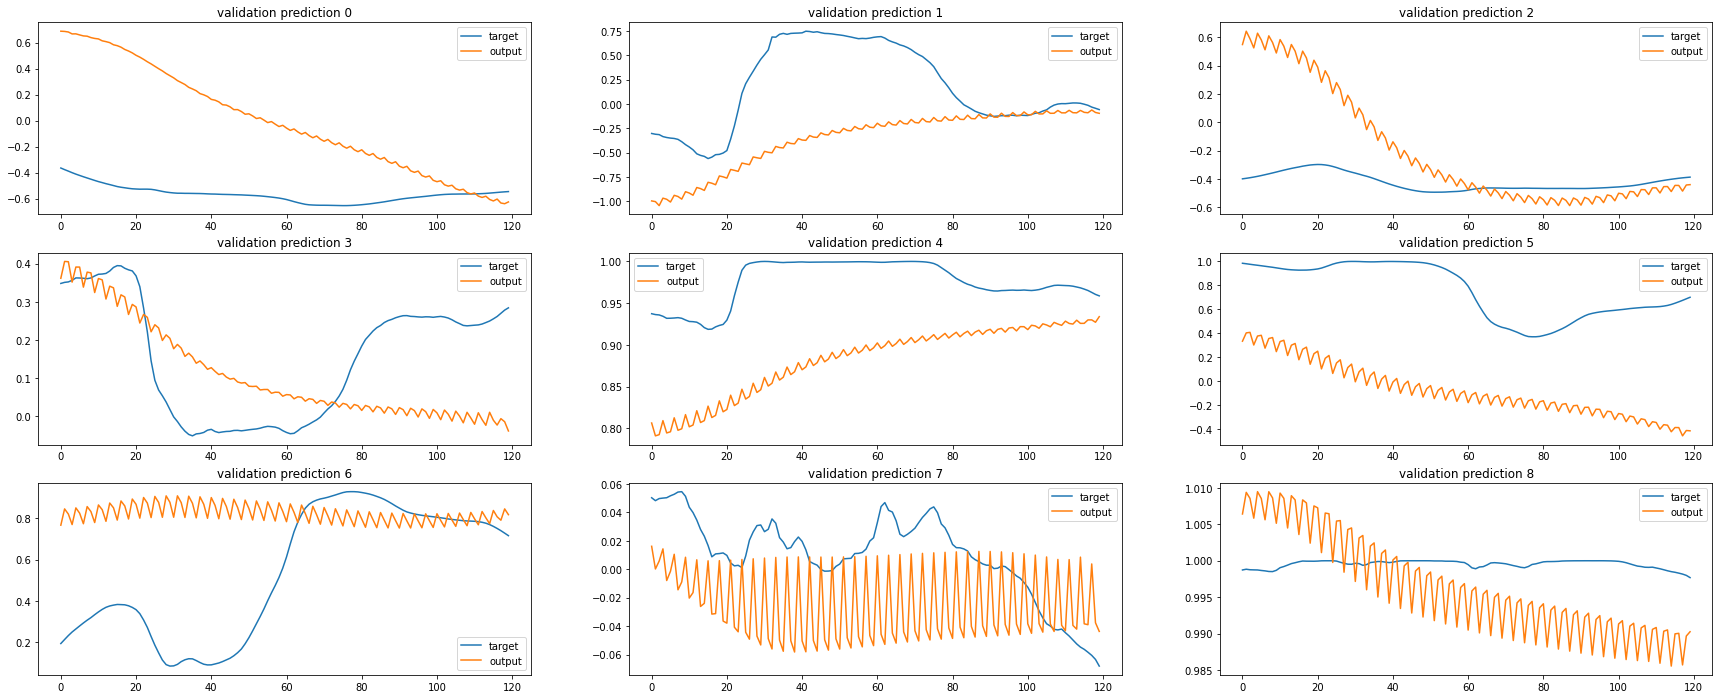

-----------------------------------------------------------------------------------------
| end of epoch  21 | time:  8.54s | valid loss 10.5507 | mean loss   2.3065
-----------------------------------------------------------------------------------------


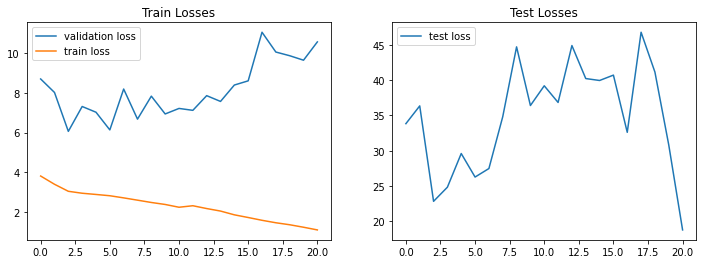

Epoch #22


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  22 |    31/  158 batches | lr 0.01703 | ms/batch 46.74192 | loss 1.06011
| epoch  22 |    62/  158 batches | lr 0.01703 | ms/batch 45.45573 | loss 1.12065
| epoch  22 |    93/  158 batches | lr 0.01703 | ms/batch 44.97083 | loss 1.01504
| epoch  22 |   124/  158 batches | lr 0.01703 | ms/batch 44.91978 | loss 0.95923
| epoch  22 |   155/  158 batches | lr 0.01703 | ms/batch 45.25831 | loss 1.04193
-----------------------------------------------------------------------------------------
| end of epoch  22 | time:  7.53s | valid loss 9.8431 | mean loss   2.2485
-----------------------------------------------------------------------------------------
Epoch #23


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  23 |    31/  158 batches | lr 0.01618 | ms/batch 46.72362 | loss 0.98348
| epoch  23 |    62/  158 batches | lr 0.01618 | ms/batch 45.85827 | loss 0.94569
| epoch  23 |    93/  158 batches | lr 0.01618 | ms/batch 45.85906 | loss 0.99477
| epoch  23 |   124/  158 batches | lr 0.01618 | ms/batch 45.24540 | loss 0.91639
| epoch  23 |   155/  158 batches | lr 0.01618 | ms/batch 45.73651 | loss 0.87460
-----------------------------------------------------------------------------------------
| end of epoch  23 | time:  7.60s | valid loss 11.4038 | mean loss   2.1914
-----------------------------------------------------------------------------------------
Epoch #24


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  24 |    31/  158 batches | lr 0.01537 | ms/batch 48.37008 | loss 0.89579
| epoch  24 |    62/  158 batches | lr 0.01537 | ms/batch 46.22766 | loss 0.89267
| epoch  24 |    93/  158 batches | lr 0.01537 | ms/batch 45.73907 | loss 0.92243
| epoch  24 |   124/  158 batches | lr 0.01537 | ms/batch 45.66791 | loss 0.86011
| epoch  24 |   155/  158 batches | lr 0.01537 | ms/batch 45.00977 | loss 0.76813
-----------------------------------------------------------------------------------------
| end of epoch  24 | time:  7.66s | valid loss 10.3752 | mean loss   2.1359
-----------------------------------------------------------------------------------------
Epoch #25


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  25 |    31/  158 batches | lr 0.01460 | ms/batch 46.27024 | loss 0.83523
| epoch  25 |    62/  158 batches | lr 0.01460 | ms/batch 44.76200 | loss 0.95397
| epoch  25 |    93/  158 batches | lr 0.01460 | ms/batch 45.42526 | loss 0.79301
| epoch  25 |   124/  158 batches | lr 0.01460 | ms/batch 46.17633 | loss 0.75427
| epoch  25 |   155/  158 batches | lr 0.01460 | ms/batch 45.62709 | loss 0.75624
-----------------------------------------------------------------------------------------
| end of epoch  25 | time:  7.57s | valid loss 11.6200 | mean loss   2.0829
-----------------------------------------------------------------------------------------
Epoch #26


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  26 |    31/  158 batches | lr 0.01387 | ms/batch 46.28330 | loss 0.77149
| epoch  26 |    62/  158 batches | lr 0.01387 | ms/batch 45.18325 | loss 0.72978
| epoch  26 |    93/  158 batches | lr 0.01387 | ms/batch 44.83240 | loss 0.73942
| epoch  26 |   124/  158 batches | lr 0.01387 | ms/batch 44.78498 | loss 0.74376
| epoch  26 |   155/  158 batches | lr 0.01387 | ms/batch 45.13180 | loss 0.70535
validation prediction


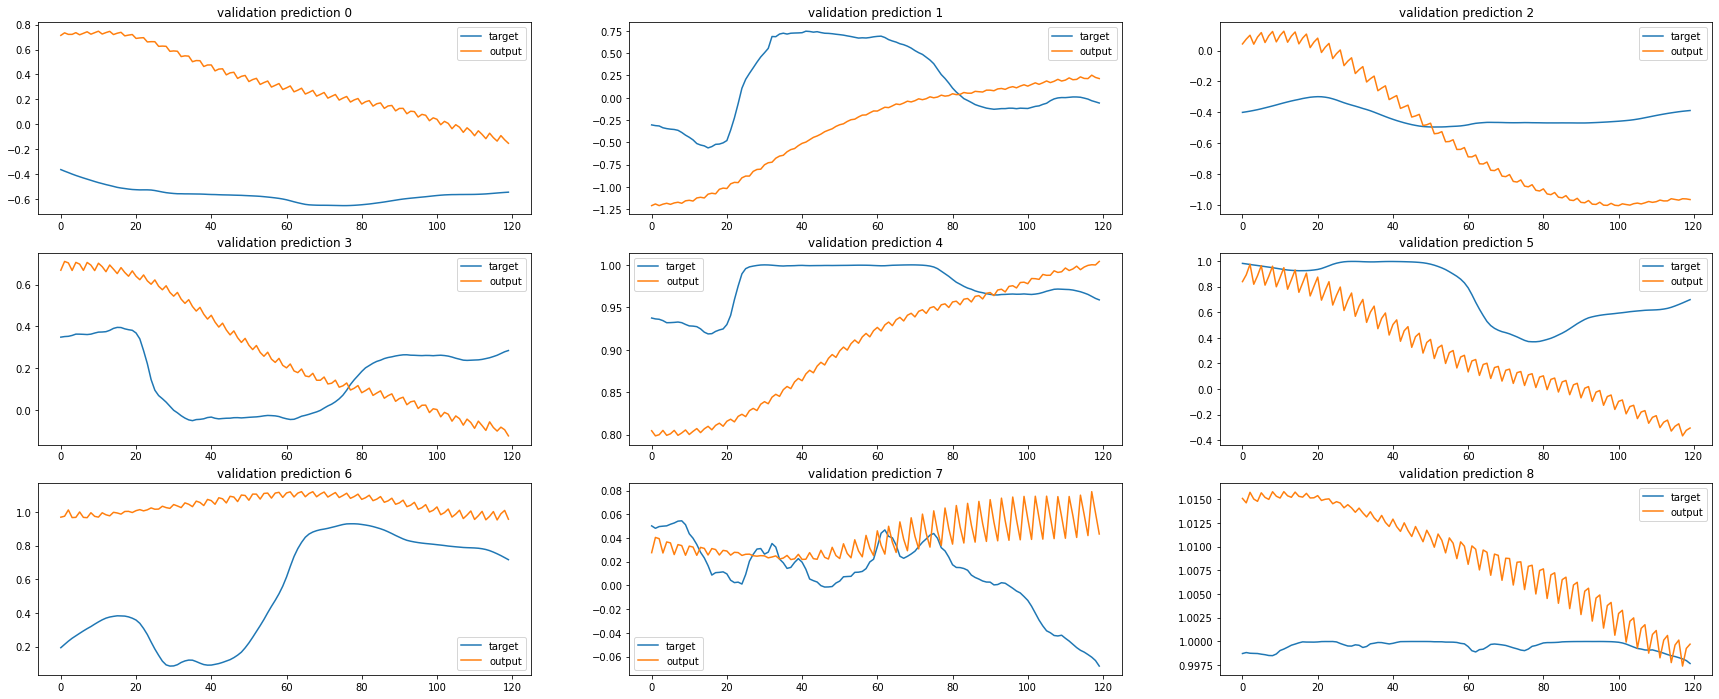

-----------------------------------------------------------------------------------------
| end of epoch  26 | time:  8.61s | valid loss 11.9340 | mean loss   2.0309
-----------------------------------------------------------------------------------------


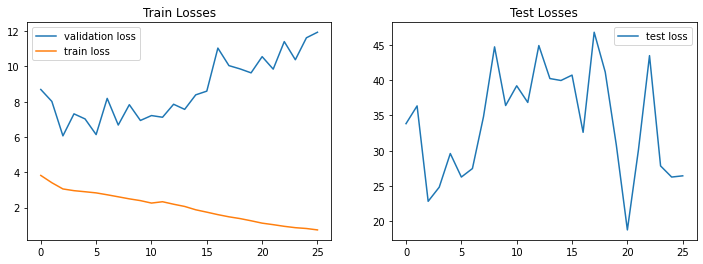

Epoch #27


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  27 |    31/  158 batches | lr 0.01318 | ms/batch 46.45105 | loss 0.79661
| epoch  27 |    62/  158 batches | lr 0.01318 | ms/batch 44.96331 | loss 0.74051
| epoch  27 |    93/  158 batches | lr 0.01318 | ms/batch 44.60372 | loss 0.64610
| epoch  27 |   124/  158 batches | lr 0.01318 | ms/batch 45.85535 | loss 0.73311
| epoch  27 |   155/  158 batches | lr 0.01318 | ms/batch 45.60862 | loss 0.63513
-----------------------------------------------------------------------------------------
| end of epoch  27 | time:  7.53s | valid loss 10.0855 | mean loss   1.9818
-----------------------------------------------------------------------------------------
Epoch #28


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  28 |    31/  158 batches | lr 0.01252 | ms/batch 47.70371 | loss 0.56733
| epoch  28 |    62/  158 batches | lr 0.01252 | ms/batch 45.80882 | loss 0.68721
| epoch  28 |    93/  158 batches | lr 0.01252 | ms/batch 45.25898 | loss 0.66664
| epoch  28 |   124/  158 batches | lr 0.01252 | ms/batch 45.07346 | loss 0.62821
| epoch  28 |   155/  158 batches | lr 0.01252 | ms/batch 45.30935 | loss 0.63736
-----------------------------------------------------------------------------------------
| end of epoch  28 | time:  7.61s | valid loss 10.9619 | mean loss   1.9336
-----------------------------------------------------------------------------------------
Epoch #29


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  29 |    31/  158 batches | lr 0.01189 | ms/batch 45.77055 | loss 0.62530
| epoch  29 |    62/  158 batches | lr 0.01189 | ms/batch 45.43957 | loss 0.57706
| epoch  29 |    93/  158 batches | lr 0.01189 | ms/batch 46.43984 | loss 0.63108
| epoch  29 |   124/  158 batches | lr 0.01189 | ms/batch 45.59535 | loss 0.55785
| epoch  29 |   155/  158 batches | lr 0.01189 | ms/batch 45.02627 | loss 0.50984
-----------------------------------------------------------------------------------------
| end of epoch  29 | time:  7.57s | valid loss 10.1329 | mean loss   1.8869
-----------------------------------------------------------------------------------------
Epoch #30


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  30 |    31/  158 batches | lr 0.01130 | ms/batch 46.33713 | loss 0.55835
| epoch  30 |    62/  158 batches | lr 0.01130 | ms/batch 45.97942 | loss 0.49337
| epoch  30 |    93/  158 batches | lr 0.01130 | ms/batch 45.08580 | loss 0.62284
| epoch  30 |   124/  158 batches | lr 0.01130 | ms/batch 44.79374 | loss 0.58634
| epoch  30 |   155/  158 batches | lr 0.01130 | ms/batch 44.72310 | loss 0.49147
-----------------------------------------------------------------------------------------
| end of epoch  30 | time:  7.52s | valid loss 11.1984 | mean loss   1.8424
-----------------------------------------------------------------------------------------
Epoch #31


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  31 |    31/  158 batches | lr 0.01073 | ms/batch 46.78562 | loss 0.58252
| epoch  31 |    62/  158 batches | lr 0.01073 | ms/batch 44.75541 | loss 0.49185
| epoch  31 |    93/  158 batches | lr 0.01073 | ms/batch 46.07905 | loss 0.48944
| epoch  31 |   124/  158 batches | lr 0.01073 | ms/batch 46.26346 | loss 0.49624
| epoch  31 |   155/  158 batches | lr 0.01073 | ms/batch 44.92152 | loss 0.51977
validation prediction


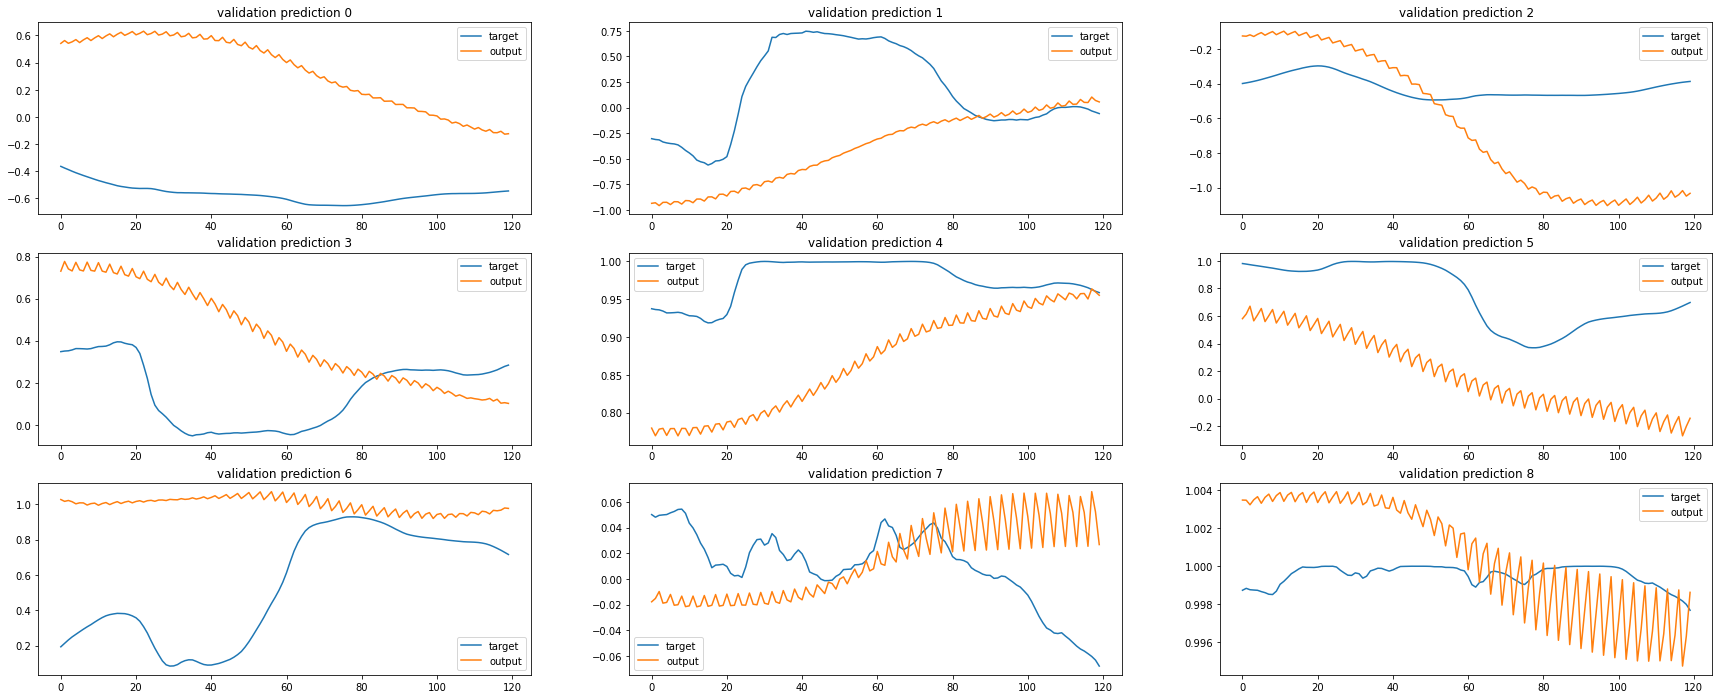

-----------------------------------------------------------------------------------------
| end of epoch  31 | time:  8.55s | valid loss 9.9418 | mean loss   1.7995
-----------------------------------------------------------------------------------------


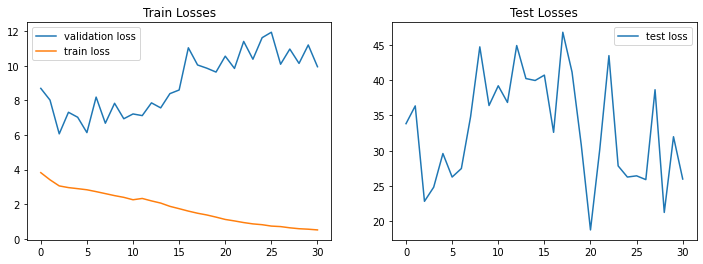

Epoch #32


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  32 |    31/  158 batches | lr 0.01020 | ms/batch 46.33527 | loss 0.48195
| epoch  32 |    62/  158 batches | lr 0.01020 | ms/batch 44.86269 | loss 0.45180
| epoch  32 |    93/  158 batches | lr 0.01020 | ms/batch 44.99623 | loss 0.50449
| epoch  32 |   124/  158 batches | lr 0.01020 | ms/batch 45.35575 | loss 0.51171
| epoch  32 |   155/  158 batches | lr 0.01020 | ms/batch 46.94219 | loss 0.53933
-----------------------------------------------------------------------------------------
| end of epoch  32 | time:  7.56s | valid loss 10.3089 | mean loss   1.7587
-----------------------------------------------------------------------------------------
Epoch #33


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  33 |    31/  158 batches | lr 0.00969 | ms/batch 46.28718 | loss 0.48670
| epoch  33 |    62/  158 batches | lr 0.00969 | ms/batch 46.51308 | loss 0.47044
| epoch  33 |    93/  158 batches | lr 0.00969 | ms/batch 45.24626 | loss 0.45110
| epoch  33 |   124/  158 batches | lr 0.00969 | ms/batch 44.96637 | loss 0.45200
| epoch  33 |   155/  158 batches | lr 0.00969 | ms/batch 46.30519 | loss 0.47747
-----------------------------------------------------------------------------------------
| end of epoch  33 | time:  7.61s | valid loss 11.1626 | mean loss   1.7195
-----------------------------------------------------------------------------------------
Epoch #34


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  34 |    31/  158 batches | lr 0.00920 | ms/batch 47.89429 | loss 0.46389
| epoch  34 |    62/  158 batches | lr 0.00920 | ms/batch 45.14610 | loss 0.50846
| epoch  34 |    93/  158 batches | lr 0.00920 | ms/batch 45.86891 | loss 0.43883
| epoch  34 |   124/  158 batches | lr 0.00920 | ms/batch 45.35872 | loss 0.39472
| epoch  34 |   155/  158 batches | lr 0.00920 | ms/batch 45.91587 | loss 0.45227
-----------------------------------------------------------------------------------------
| end of epoch  34 | time:  7.64s | valid loss 10.3469 | mean loss   1.6821
-----------------------------------------------------------------------------------------
Epoch #35


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  35 |    31/  158 batches | lr 0.00874 | ms/batch 46.79821 | loss 0.39148
| epoch  35 |    62/  158 batches | lr 0.00874 | ms/batch 45.00256 | loss 0.37885
| epoch  35 |    93/  158 batches | lr 0.00874 | ms/batch 45.34005 | loss 0.39316
| epoch  35 |   124/  158 batches | lr 0.00874 | ms/batch 45.13050 | loss 0.47611
| epoch  35 |   155/  158 batches | lr 0.00874 | ms/batch 45.86246 | loss 0.50140
-----------------------------------------------------------------------------------------
| end of epoch  35 | time:  7.57s | valid loss 10.5685 | mean loss   1.6462
-----------------------------------------------------------------------------------------
Epoch #36


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  36 |    31/  158 batches | lr 0.00830 | ms/batch 46.92876 | loss 0.44101
| epoch  36 |    62/  158 batches | lr 0.00830 | ms/batch 45.67058 | loss 0.38597
| epoch  36 |    93/  158 batches | lr 0.00830 | ms/batch 45.87523 | loss 0.41421
| epoch  36 |   124/  158 batches | lr 0.00830 | ms/batch 45.05651 | loss 0.42514
| epoch  36 |   155/  158 batches | lr 0.00830 | ms/batch 45.26504 | loss 0.44511
validation prediction


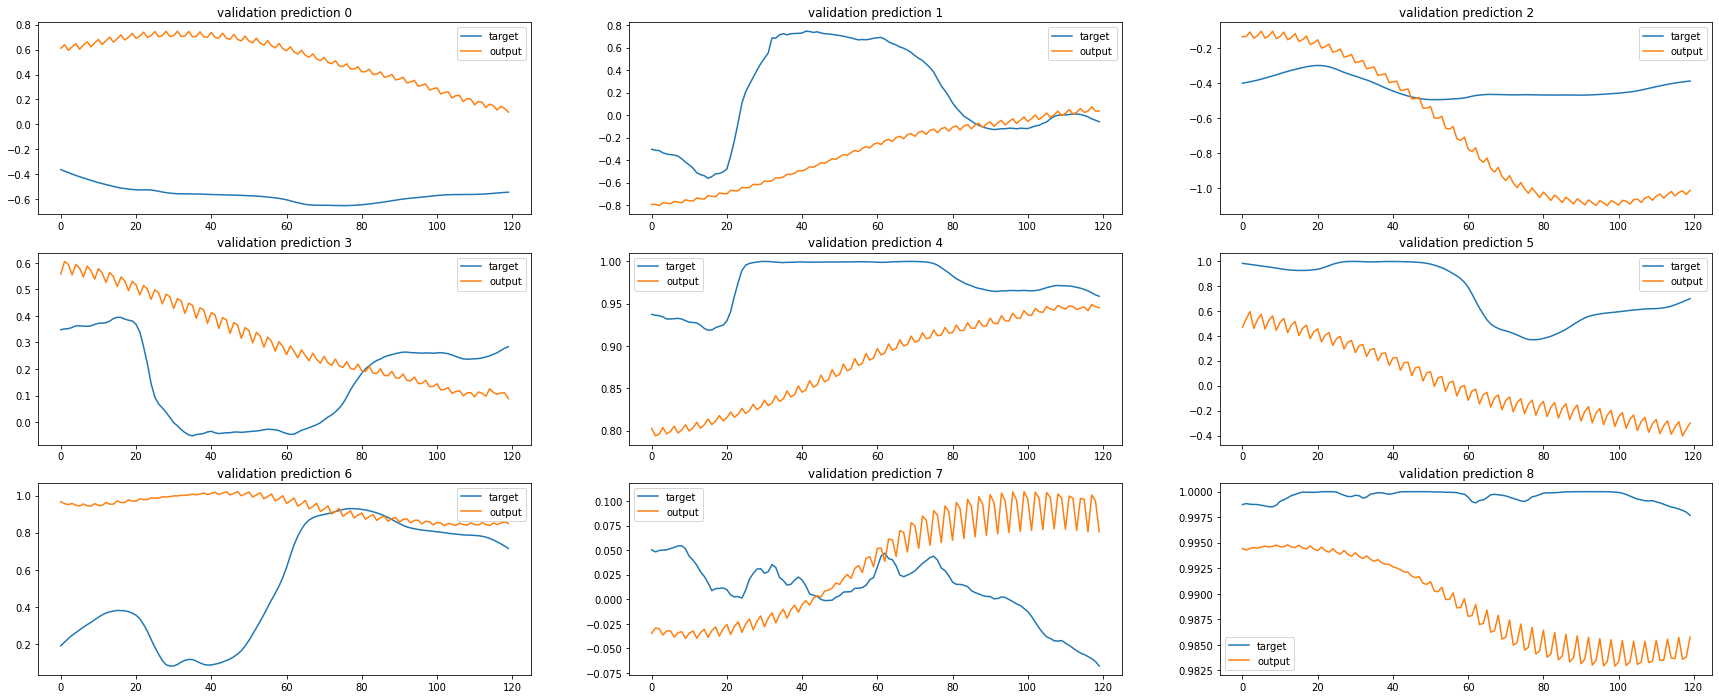

-----------------------------------------------------------------------------------------
| end of epoch  36 | time:  8.71s | valid loss 10.2461 | mean loss   1.6121
-----------------------------------------------------------------------------------------


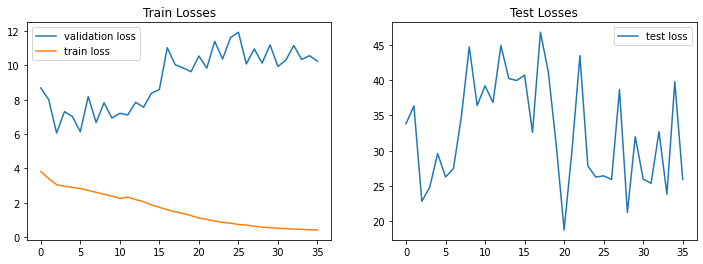

Epoch #37


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  37 |    31/  158 batches | lr 0.00789 | ms/batch 46.78390 | loss 0.43924
| epoch  37 |    62/  158 batches | lr 0.00789 | ms/batch 45.55555 | loss 0.37942
| epoch  37 |    93/  158 batches | lr 0.00789 | ms/batch 44.89973 | loss 0.37265
| epoch  37 |   124/  158 batches | lr 0.00789 | ms/batch 45.10636 | loss 0.39050
| epoch  37 |   155/  158 batches | lr 0.00789 | ms/batch 44.87366 | loss 0.40470
-----------------------------------------------------------------------------------------
| end of epoch  37 | time:  7.52s | valid loss 10.2143 | mean loss   1.5792
-----------------------------------------------------------------------------------------
Epoch #38


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  38 |    31/  158 batches | lr 0.00749 | ms/batch 47.33559 | loss 0.37887
| epoch  38 |    62/  158 batches | lr 0.00749 | ms/batch 46.28070 | loss 0.34353
| epoch  38 |    93/  158 batches | lr 0.00749 | ms/batch 44.63033 | loss 0.43096
| epoch  38 |   124/  158 batches | lr 0.00749 | ms/batch 44.73271 | loss 0.36405
| epoch  38 |   155/  158 batches | lr 0.00749 | ms/batch 44.79967 | loss 0.41387
-----------------------------------------------------------------------------------------
| end of epoch  38 | time:  7.54s | valid loss 10.3162 | mean loss   1.5477
-----------------------------------------------------------------------------------------
Epoch #39


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  39 |    31/  158 batches | lr 0.00712 | ms/batch 46.04850 | loss 0.41111
| epoch  39 |    62/  158 batches | lr 0.00712 | ms/batch 44.62731 | loss 0.33597
| epoch  39 |    93/  158 batches | lr 0.00712 | ms/batch 44.53049 | loss 0.32769
| epoch  39 |   124/  158 batches | lr 0.00712 | ms/batch 44.55879 | loss 0.45867
| epoch  39 |   155/  158 batches | lr 0.00712 | ms/batch 45.86978 | loss 0.33717
-----------------------------------------------------------------------------------------
| end of epoch  39 | time:  7.48s | valid loss 10.7840 | mean loss   1.5176
-----------------------------------------------------------------------------------------
Epoch #40


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  40 |    31/  158 batches | lr 0.00676 | ms/batch 46.64709 | loss 0.36652
| epoch  40 |    62/  158 batches | lr 0.00676 | ms/batch 45.61114 | loss 0.37244
| epoch  40 |    93/  158 batches | lr 0.00676 | ms/batch 45.36364 | loss 0.39278
| epoch  40 |   124/  158 batches | lr 0.00676 | ms/batch 44.69299 | loss 0.34250
| epoch  40 |   155/  158 batches | lr 0.00676 | ms/batch 44.86562 | loss 0.34909
-----------------------------------------------------------------------------------------
| end of epoch  40 | time:  7.54s | valid loss 10.4852 | mean loss   1.4887
-----------------------------------------------------------------------------------------
Epoch #41


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  41 |    31/  158 batches | lr 0.00643 | ms/batch 46.18724 | loss 0.38596
| epoch  41 |    62/  158 batches | lr 0.00643 | ms/batch 46.98696 | loss 0.37097
| epoch  41 |    93/  158 batches | lr 0.00643 | ms/batch 44.62674 | loss 0.32471
| epoch  41 |   124/  158 batches | lr 0.00643 | ms/batch 44.65385 | loss 0.35153
| epoch  41 |   155/  158 batches | lr 0.00643 | ms/batch 44.73806 | loss 0.36930
validation prediction


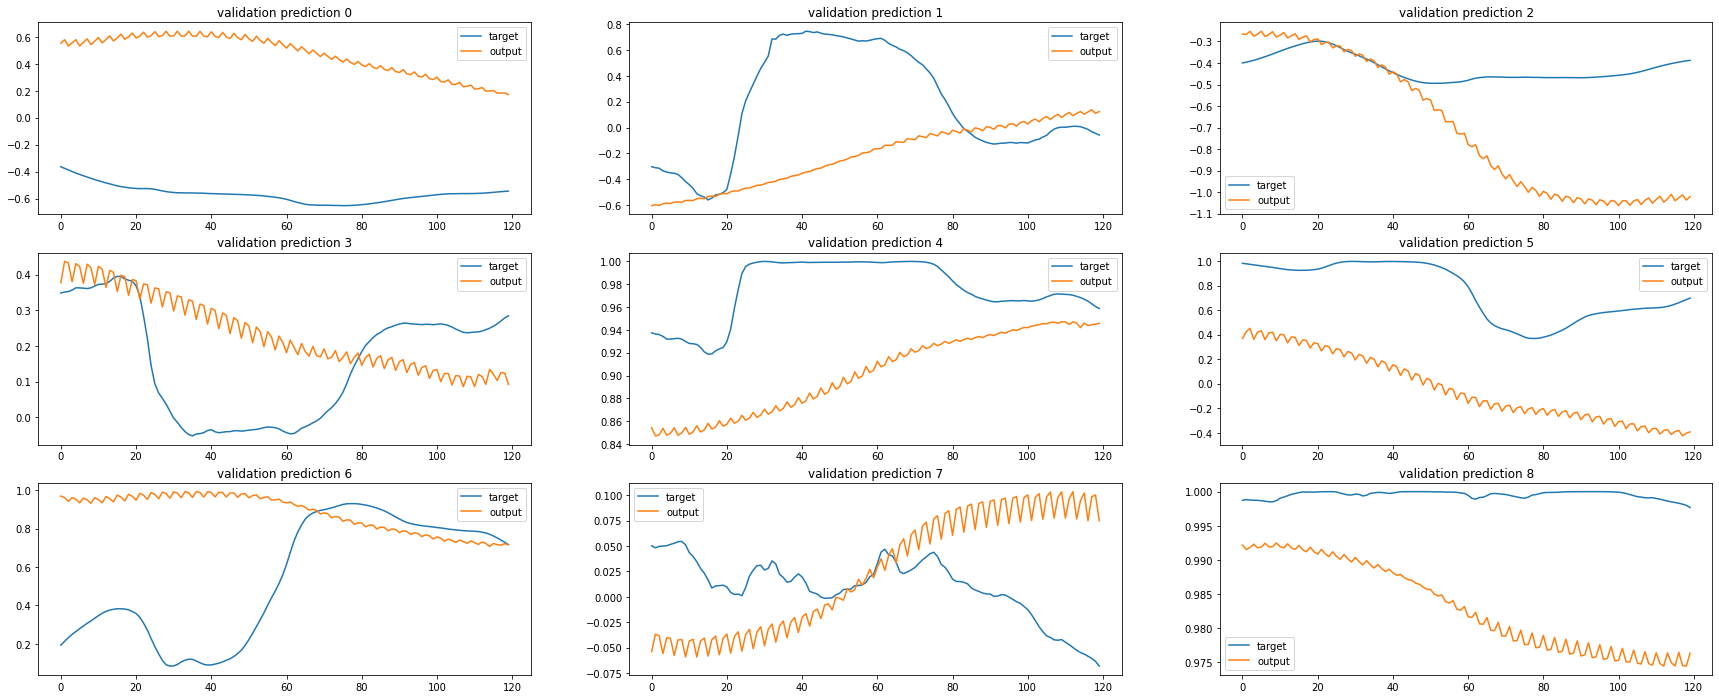

-----------------------------------------------------------------------------------------
| end of epoch  41 | time:  8.51s | valid loss 10.7311 | mean loss   1.4611
-----------------------------------------------------------------------------------------


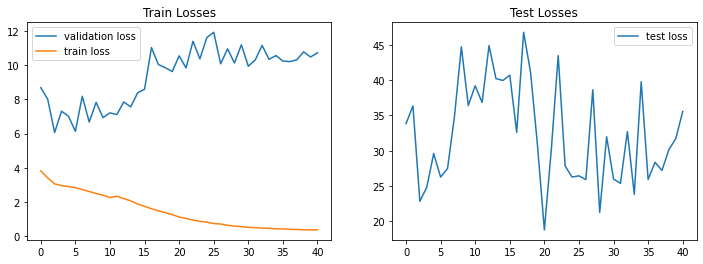

Epoch #42


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  42 |    31/  158 batches | lr 0.00610 | ms/batch 46.94776 | loss 0.38515
| epoch  42 |    62/  158 batches | lr 0.00610 | ms/batch 44.91717 | loss 0.36639
| epoch  42 |    93/  158 batches | lr 0.00610 | ms/batch 44.52329 | loss 0.33289
| epoch  42 |   124/  158 batches | lr 0.00610 | ms/batch 44.83109 | loss 0.33167
| epoch  42 |   155/  158 batches | lr 0.00610 | ms/batch 44.67537 | loss 0.31572
-----------------------------------------------------------------------------------------
| end of epoch  42 | time:  7.48s | valid loss 10.5525 | mean loss   1.4345
-----------------------------------------------------------------------------------------
Epoch #43


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  43 |    31/  158 batches | lr 0.00580 | ms/batch 46.01606 | loss 0.33994
| epoch  43 |    62/  158 batches | lr 0.00580 | ms/batch 44.92255 | loss 0.30243
| epoch  43 |    93/  158 batches | lr 0.00580 | ms/batch 44.41868 | loss 0.33435
| epoch  43 |   124/  158 batches | lr 0.00580 | ms/batch 44.55501 | loss 0.34858
| epoch  43 |   155/  158 batches | lr 0.00580 | ms/batch 44.75876 | loss 0.32575
-----------------------------------------------------------------------------------------
| end of epoch  43 | time:  7.45s | valid loss 10.3651 | mean loss   1.4088
-----------------------------------------------------------------------------------------
Epoch #44


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  44 |    31/  158 batches | lr 0.00551 | ms/batch 46.30858 | loss 0.35544
| epoch  44 |    62/  158 batches | lr 0.00551 | ms/batch 44.74300 | loss 0.34283
| epoch  44 |    93/  158 batches | lr 0.00551 | ms/batch 44.79685 | loss 0.32703
| epoch  44 |   124/  158 batches | lr 0.00551 | ms/batch 44.62235 | loss 0.29650
| epoch  44 |   155/  158 batches | lr 0.00551 | ms/batch 45.02320 | loss 0.31465
-----------------------------------------------------------------------------------------
| end of epoch  44 | time:  7.47s | valid loss 10.7254 | mean loss   1.3842
-----------------------------------------------------------------------------------------
Epoch #45


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  45 |    31/  158 batches | lr 0.00523 | ms/batch 46.21211 | loss 0.31777
| epoch  45 |    62/  158 batches | lr 0.00523 | ms/batch 44.59297 | loss 0.33573
| epoch  45 |    93/  158 batches | lr 0.00523 | ms/batch 44.64182 | loss 0.32146
| epoch  45 |   124/  158 batches | lr 0.00523 | ms/batch 44.45478 | loss 0.30493
| epoch  45 |   155/  158 batches | lr 0.00523 | ms/batch 44.60759 | loss 0.29244
-----------------------------------------------------------------------------------------
| end of epoch  45 | time:  7.44s | valid loss 10.4837 | mean loss   1.3604
-----------------------------------------------------------------------------------------
Epoch #46


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  46 |    31/  158 batches | lr 0.00497 | ms/batch 46.15253 | loss 0.33161
| epoch  46 |    62/  158 batches | lr 0.00497 | ms/batch 44.78996 | loss 0.32009
| epoch  46 |    93/  158 batches | lr 0.00497 | ms/batch 44.50777 | loss 0.32382
| epoch  46 |   124/  158 batches | lr 0.00497 | ms/batch 44.62527 | loss 0.29629
| epoch  46 |   155/  158 batches | lr 0.00497 | ms/batch 44.94353 | loss 0.26924
validation prediction


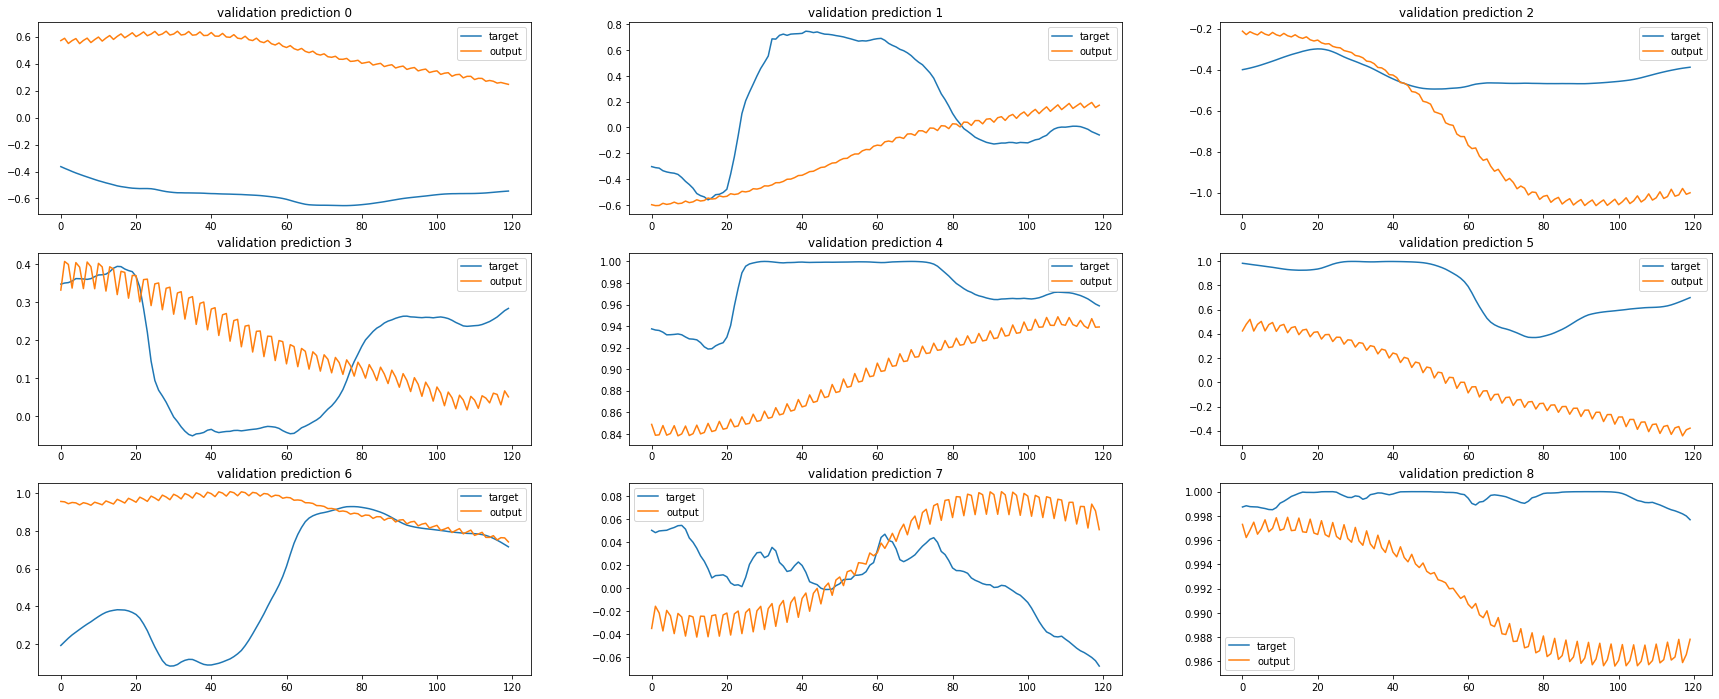

-----------------------------------------------------------------------------------------
| end of epoch  46 | time:  8.58s | valid loss 10.5273 | mean loss   1.3374
-----------------------------------------------------------------------------------------


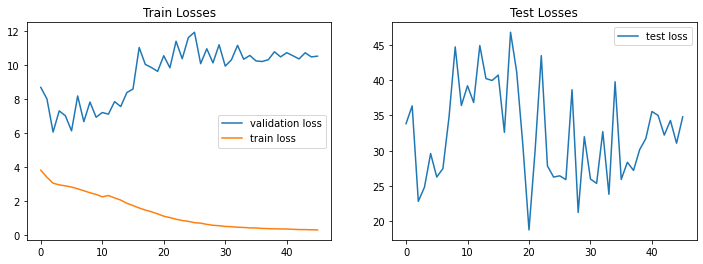

Epoch #47


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  47 |    31/  158 batches | lr 0.00472 | ms/batch 46.35103 | loss 0.28243
| epoch  47 |    62/  158 batches | lr 0.00472 | ms/batch 44.89262 | loss 0.34140
| epoch  47 |    93/  158 batches | lr 0.00472 | ms/batch 44.56248 | loss 0.29746
| epoch  47 |   124/  158 batches | lr 0.00472 | ms/batch 44.83970 | loss 0.31225
| epoch  47 |   155/  158 batches | lr 0.00472 | ms/batch 45.19787 | loss 0.28084
-----------------------------------------------------------------------------------------
| end of epoch  47 | time:  7.48s | valid loss 10.5839 | mean loss   1.3154
-----------------------------------------------------------------------------------------
Epoch #48


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  48 |    31/  158 batches | lr 0.00449 | ms/batch 46.79499 | loss 0.27781
| epoch  48 |    62/  158 batches | lr 0.00449 | ms/batch 46.36293 | loss 0.31528
| epoch  48 |    93/  158 batches | lr 0.00449 | ms/batch 45.42508 | loss 0.26415
| epoch  48 |   124/  158 batches | lr 0.00449 | ms/batch 45.07426 | loss 0.32848
| epoch  48 |   155/  158 batches | lr 0.00449 | ms/batch 45.07108 | loss 0.29243
-----------------------------------------------------------------------------------------
| end of epoch  48 | time:  7.58s | valid loss 10.3731 | mean loss   1.2942
-----------------------------------------------------------------------------------------
Epoch #49


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  49 |    31/  158 batches | lr 0.00426 | ms/batch 46.38089 | loss 0.25364
| epoch  49 |    62/  158 batches | lr 0.00426 | ms/batch 46.11434 | loss 0.27598
| epoch  49 |    93/  158 batches | lr 0.00426 | ms/batch 45.82690 | loss 0.30635
| epoch  49 |   124/  158 batches | lr 0.00426 | ms/batch 45.28735 | loss 0.28402
| epoch  49 |   155/  158 batches | lr 0.00426 | ms/batch 44.75097 | loss 0.34765
-----------------------------------------------------------------------------------------
| end of epoch  49 | time:  7.58s | valid loss 10.4734 | mean loss   1.2737
-----------------------------------------------------------------------------------------
Epoch #50


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  50 |    31/  158 batches | lr 0.00405 | ms/batch 46.27944 | loss 0.30307
| epoch  50 |    62/  158 batches | lr 0.00405 | ms/batch 44.93596 | loss 0.32541
| epoch  50 |    93/  158 batches | lr 0.00405 | ms/batch 44.93662 | loss 0.27333
| epoch  50 |   124/  158 batches | lr 0.00405 | ms/batch 45.62580 | loss 0.25802
| epoch  50 |   155/  158 batches | lr 0.00405 | ms/batch 46.22033 | loss 0.31205
-----------------------------------------------------------------------------------------
| end of epoch  50 | time:  7.56s | valid loss 10.4908 | mean loss   1.2540
-----------------------------------------------------------------------------------------
Epoch #51


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  51 |    31/  158 batches | lr 0.00385 | ms/batch 46.99439 | loss 0.26913
| epoch  51 |    62/  158 batches | lr 0.00385 | ms/batch 45.66513 | loss 0.29478
| epoch  51 |    93/  158 batches | lr 0.00385 | ms/batch 44.82165 | loss 0.26487
| epoch  51 |   124/  158 batches | lr 0.00385 | ms/batch 46.52847 | loss 0.25436
| epoch  51 |   155/  158 batches | lr 0.00385 | ms/batch 44.79828 | loss 0.30020
validation prediction


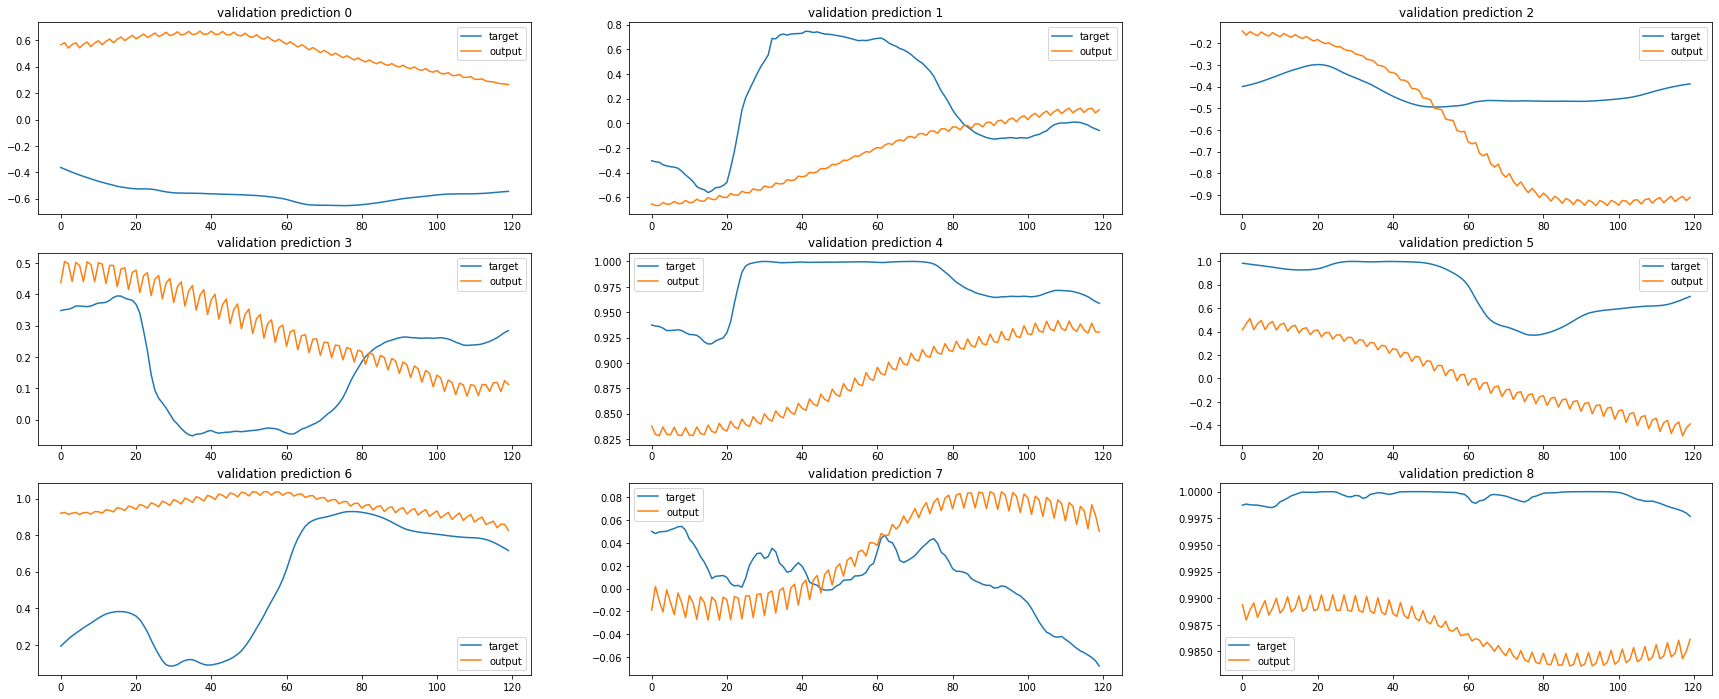

-----------------------------------------------------------------------------------------
| end of epoch  51 | time:  8.56s | valid loss 10.4367 | mean loss   1.2348
-----------------------------------------------------------------------------------------


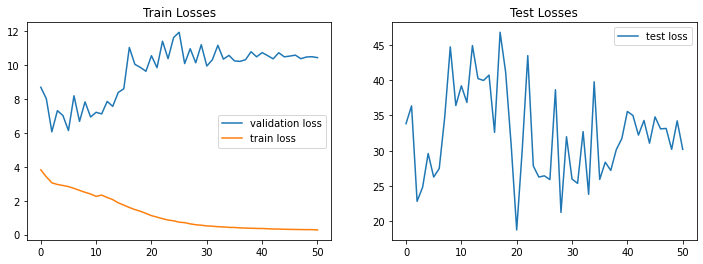

Epoch #52


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  52 |    31/  158 batches | lr 0.00365 | ms/batch 46.47047 | loss 0.26844
| epoch  52 |    62/  158 batches | lr 0.00365 | ms/batch 44.47603 | loss 0.27015
| epoch  52 |    93/  158 batches | lr 0.00365 | ms/batch 44.68250 | loss 0.24684
| epoch  52 |   124/  158 batches | lr 0.00365 | ms/batch 44.65347 | loss 0.30749
| epoch  52 |   155/  158 batches | lr 0.00365 | ms/batch 44.89924 | loss 0.27183
-----------------------------------------------------------------------------------------
| end of epoch  52 | time:  7.46s | valid loss 10.6408 | mean loss   1.2163
-----------------------------------------------------------------------------------------
Epoch #53


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  53 |    31/  158 batches | lr 0.00347 | ms/batch 47.51669 | loss 0.26099
| epoch  53 |    62/  158 batches | lr 0.00347 | ms/batch 46.09368 | loss 0.28605
| epoch  53 |    93/  158 batches | lr 0.00347 | ms/batch 46.19168 | loss 0.24135
| epoch  53 |   124/  158 batches | lr 0.00347 | ms/batch 45.46329 | loss 0.30460
| epoch  53 |   155/  158 batches | lr 0.00347 | ms/batch 44.64214 | loss 0.25403
-----------------------------------------------------------------------------------------
| end of epoch  53 | time:  7.61s | valid loss 10.6071 | mean loss   1.1984
-----------------------------------------------------------------------------------------
Epoch #54


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  54 |    31/  158 batches | lr 0.00330 | ms/batch 46.09328 | loss 0.25855
| epoch  54 |    62/  158 batches | lr 0.00330 | ms/batch 44.58111 | loss 0.25862
| epoch  54 |    93/  158 batches | lr 0.00330 | ms/batch 44.62996 | loss 0.30986
| epoch  54 |   124/  158 batches | lr 0.00330 | ms/batch 44.48732 | loss 0.22232
| epoch  54 |   155/  158 batches | lr 0.00330 | ms/batch 45.13761 | loss 0.24380
-----------------------------------------------------------------------------------------
| end of epoch  54 | time:  7.46s | valid loss 10.5023 | mean loss   1.1810
-----------------------------------------------------------------------------------------
Epoch #55


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  55 |    31/  158 batches | lr 0.00313 | ms/batch 47.33807 | loss 0.29721
| epoch  55 |    62/  158 batches | lr 0.00313 | ms/batch 46.26362 | loss 0.26446
| epoch  55 |    93/  158 batches | lr 0.00313 | ms/batch 44.67204 | loss 0.26868
| epoch  55 |   124/  158 batches | lr 0.00313 | ms/batch 44.68389 | loss 0.22751
| epoch  55 |   155/  158 batches | lr 0.00313 | ms/batch 46.04360 | loss 0.25550
-----------------------------------------------------------------------------------------
| end of epoch  55 | time:  7.59s | valid loss 10.4823 | mean loss   1.1642
-----------------------------------------------------------------------------------------
Epoch #56


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  56 |    31/  158 batches | lr 0.00298 | ms/batch 47.30938 | loss 0.31113
| epoch  56 |    62/  158 batches | lr 0.00298 | ms/batch 44.83286 | loss 0.25452
| epoch  56 |    93/  158 batches | lr 0.00298 | ms/batch 46.03321 | loss 0.24955
| epoch  56 |   124/  158 batches | lr 0.00298 | ms/batch 45.23866 | loss 0.23269
| epoch  56 |   155/  158 batches | lr 0.00298 | ms/batch 44.98932 | loss 0.24336
validation prediction


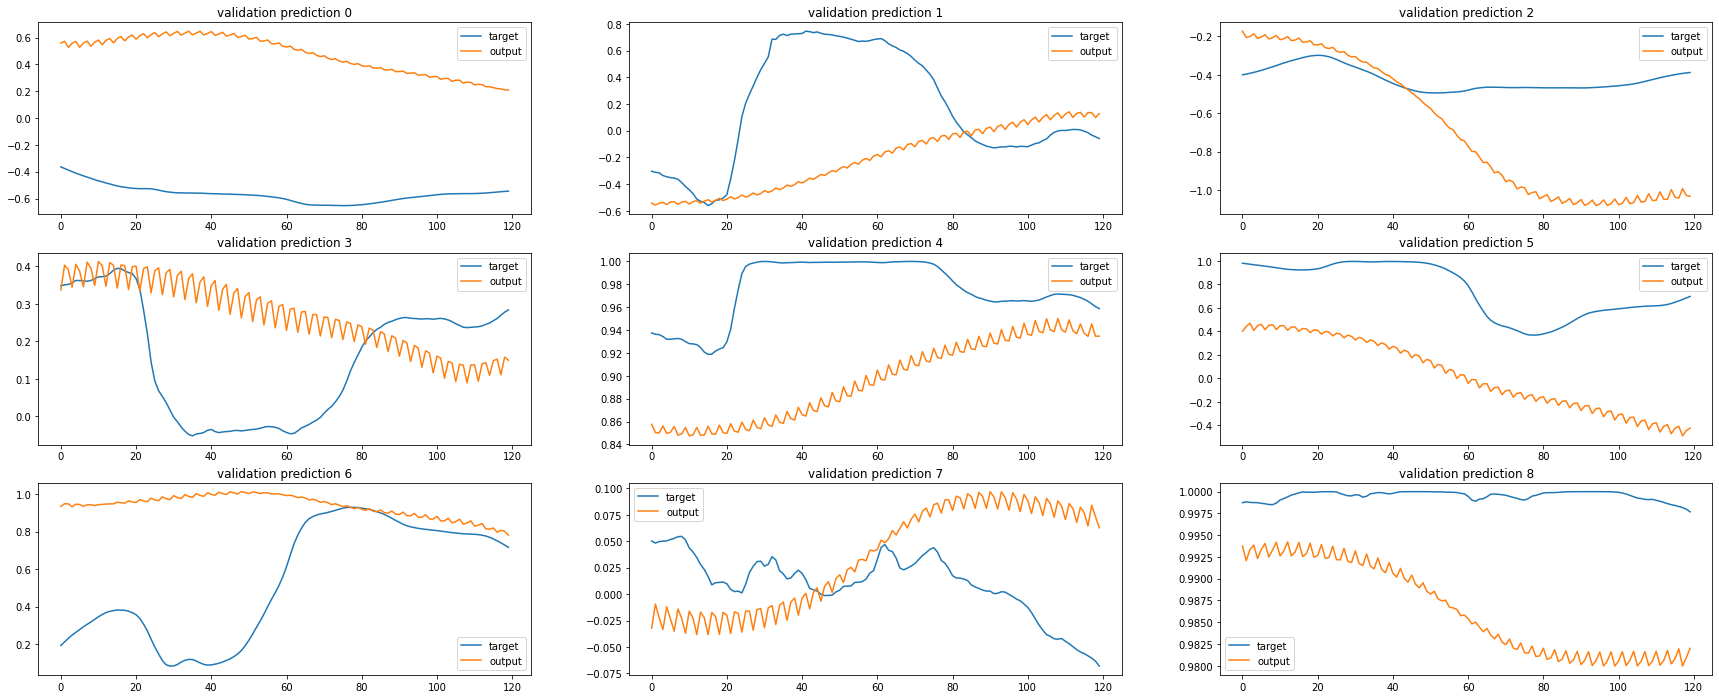

-----------------------------------------------------------------------------------------
| end of epoch  56 | time:  8.57s | valid loss 10.5071 | mean loss   1.1480
-----------------------------------------------------------------------------------------


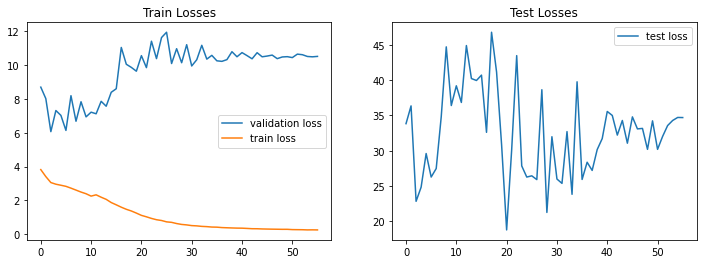

Epoch #57


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  57 |    31/  158 batches | lr 0.00283 | ms/batch 46.41581 | loss 0.25498
| epoch  57 |    62/  158 batches | lr 0.00283 | ms/batch 45.90684 | loss 0.24063
| epoch  57 |    93/  158 batches | lr 0.00283 | ms/batch 44.58615 | loss 0.23157
| epoch  57 |   124/  158 batches | lr 0.00283 | ms/batch 44.59433 | loss 0.26760
| epoch  57 |   155/  158 batches | lr 0.00283 | ms/batch 44.73232 | loss 0.26093
-----------------------------------------------------------------------------------------
| end of epoch  57 | time:  7.49s | valid loss 10.4494 | mean loss   1.1323
-----------------------------------------------------------------------------------------
Epoch #58


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  58 |    31/  158 batches | lr 0.00269 | ms/batch 51.87808 | loss 0.25450
| epoch  58 |    62/  158 batches | lr 0.00269 | ms/batch 44.88680 | loss 0.24403
| epoch  58 |    93/  158 batches | lr 0.00269 | ms/batch 44.70252 | loss 0.22680
| epoch  58 |   124/  158 batches | lr 0.00269 | ms/batch 44.73699 | loss 0.21828
| epoch  58 |   155/  158 batches | lr 0.00269 | ms/batch 45.08183 | loss 0.26760
-----------------------------------------------------------------------------------------
| end of epoch  58 | time:  7.67s | valid loss 10.6877 | mean loss   1.1169
-----------------------------------------------------------------------------------------
Epoch #59


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  59 |    31/  158 batches | lr 0.00255 | ms/batch 46.37698 | loss 0.22988
| epoch  59 |    62/  158 batches | lr 0.00255 | ms/batch 44.87634 | loss 0.28502
| epoch  59 |    93/  158 batches | lr 0.00255 | ms/batch 44.63701 | loss 0.22953
| epoch  59 |   124/  158 batches | lr 0.00255 | ms/batch 44.79016 | loss 0.23058
| epoch  59 |   155/  158 batches | lr 0.00255 | ms/batch 44.85899 | loss 0.24240
-----------------------------------------------------------------------------------------
| end of epoch  59 | time:  7.48s | valid loss 10.7033 | mean loss   1.1021
-----------------------------------------------------------------------------------------
Epoch #60


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  60 |    31/  158 batches | lr 0.00242 | ms/batch 46.54967 | loss 0.26218
| epoch  60 |    62/  158 batches | lr 0.00242 | ms/batch 45.06988 | loss 0.22726
| epoch  60 |    93/  158 batches | lr 0.00242 | ms/batch 45.27260 | loss 0.24484
| epoch  60 |   124/  158 batches | lr 0.00242 | ms/batch 46.68063 | loss 0.22753
| epoch  60 |   155/  158 batches | lr 0.00242 | ms/batch 45.59851 | loss 0.22382
-----------------------------------------------------------------------------------------
| end of epoch  60 | time:  7.59s | valid loss 10.5486 | mean loss   1.0876
-----------------------------------------------------------------------------------------
Epoch #61


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  61 |    31/  158 batches | lr 0.00230 | ms/batch 46.49464 | loss 0.22270
| epoch  61 |    62/  158 batches | lr 0.00230 | ms/batch 44.81024 | loss 0.24550
| epoch  61 |    93/  158 batches | lr 0.00230 | ms/batch 45.21019 | loss 0.24058
| epoch  61 |   124/  158 batches | lr 0.00230 | ms/batch 45.33526 | loss 0.26961
| epoch  61 |   155/  158 batches | lr 0.00230 | ms/batch 44.79818 | loss 0.19549
validation prediction


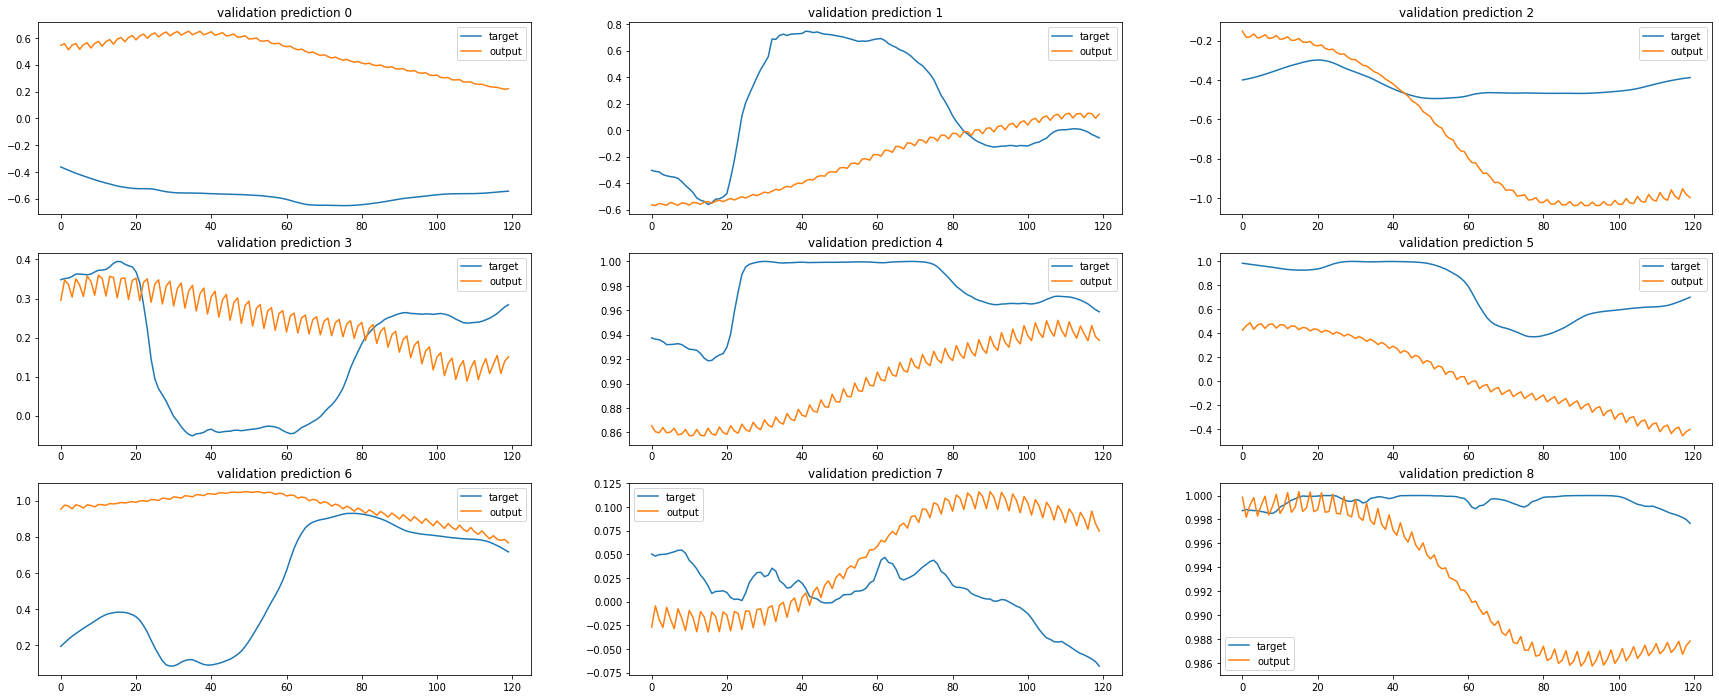

-----------------------------------------------------------------------------------------
| end of epoch  61 | time:  8.51s | valid loss 10.5722 | mean loss   1.0736
-----------------------------------------------------------------------------------------


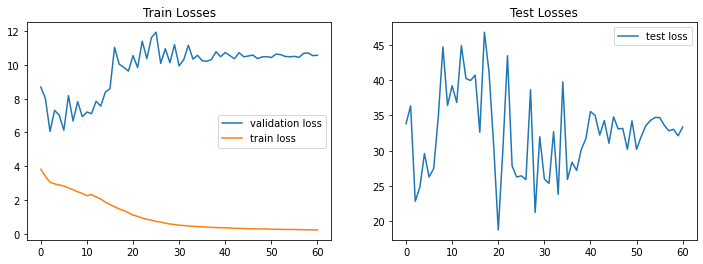

Epoch #62


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  62 |    31/  158 batches | lr 0.00219 | ms/batch 46.53776 | loss 0.24065
| epoch  62 |    62/  158 batches | lr 0.00219 | ms/batch 44.69750 | loss 0.22652
| epoch  62 |    93/  158 batches | lr 0.00219 | ms/batch 45.35104 | loss 0.21722
| epoch  62 |   124/  158 batches | lr 0.00219 | ms/batch 46.39860 | loss 0.26254
| epoch  62 |   155/  158 batches | lr 0.00219 | ms/batch 45.50312 | loss 0.22979
-----------------------------------------------------------------------------------------
| end of epoch  62 | time:  7.56s | valid loss 10.4120 | mean loss   1.0601
-----------------------------------------------------------------------------------------
Epoch #63


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  63 |    31/  158 batches | lr 0.00208 | ms/batch 47.53851 | loss 0.24335
| epoch  63 |    62/  158 batches | lr 0.00208 | ms/batch 45.27892 | loss 0.20587
| epoch  63 |    93/  158 batches | lr 0.00208 | ms/batch 48.50245 | loss 0.24312
| epoch  63 |   124/  158 batches | lr 0.00208 | ms/batch 44.75256 | loss 0.24616
| epoch  63 |   155/  158 batches | lr 0.00208 | ms/batch 44.72110 | loss 0.20759
-----------------------------------------------------------------------------------------
| end of epoch  63 | time:  7.64s | valid loss 10.4608 | mean loss   1.0469
-----------------------------------------------------------------------------------------
Epoch #64


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  64 |    31/  158 batches | lr 0.00197 | ms/batch 46.61763 | loss 0.20824
| epoch  64 |    62/  158 batches | lr 0.00197 | ms/batch 44.80009 | loss 0.23066
| epoch  64 |    93/  158 batches | lr 0.00197 | ms/batch 44.73332 | loss 0.19880
| epoch  64 |   124/  158 batches | lr 0.00197 | ms/batch 44.63319 | loss 0.21566
| epoch  64 |   155/  158 batches | lr 0.00197 | ms/batch 44.79962 | loss 0.27186
-----------------------------------------------------------------------------------------
| end of epoch  64 | time:  7.48s | valid loss 10.4156 | mean loss   1.0340
-----------------------------------------------------------------------------------------
Epoch #65


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  65 |    31/  158 batches | lr 0.00188 | ms/batch 45.99367 | loss 0.21497
| epoch  65 |    62/  158 batches | lr 0.00188 | ms/batch 45.48790 | loss 0.21131
| epoch  65 |    93/  158 batches | lr 0.00188 | ms/batch 44.99275 | loss 0.27234
| epoch  65 |   124/  158 batches | lr 0.00188 | ms/batch 44.72679 | loss 0.20360
| epoch  65 |   155/  158 batches | lr 0.00188 | ms/batch 44.76663 | loss 0.21378
-----------------------------------------------------------------------------------------
| end of epoch  65 | time:  7.51s | valid loss 10.4955 | mean loss   1.0215
-----------------------------------------------------------------------------------------
Epoch #66


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  66 |    31/  158 batches | lr 0.00178 | ms/batch 46.46504 | loss 0.26773
| epoch  66 |    62/  158 batches | lr 0.00178 | ms/batch 45.26394 | loss 0.21806
| epoch  66 |    93/  158 batches | lr 0.00178 | ms/batch 44.95435 | loss 0.19380
| epoch  66 |   124/  158 batches | lr 0.00178 | ms/batch 44.86103 | loss 0.22336
| epoch  66 |   155/  158 batches | lr 0.00178 | ms/batch 46.59148 | loss 0.20206
validation prediction


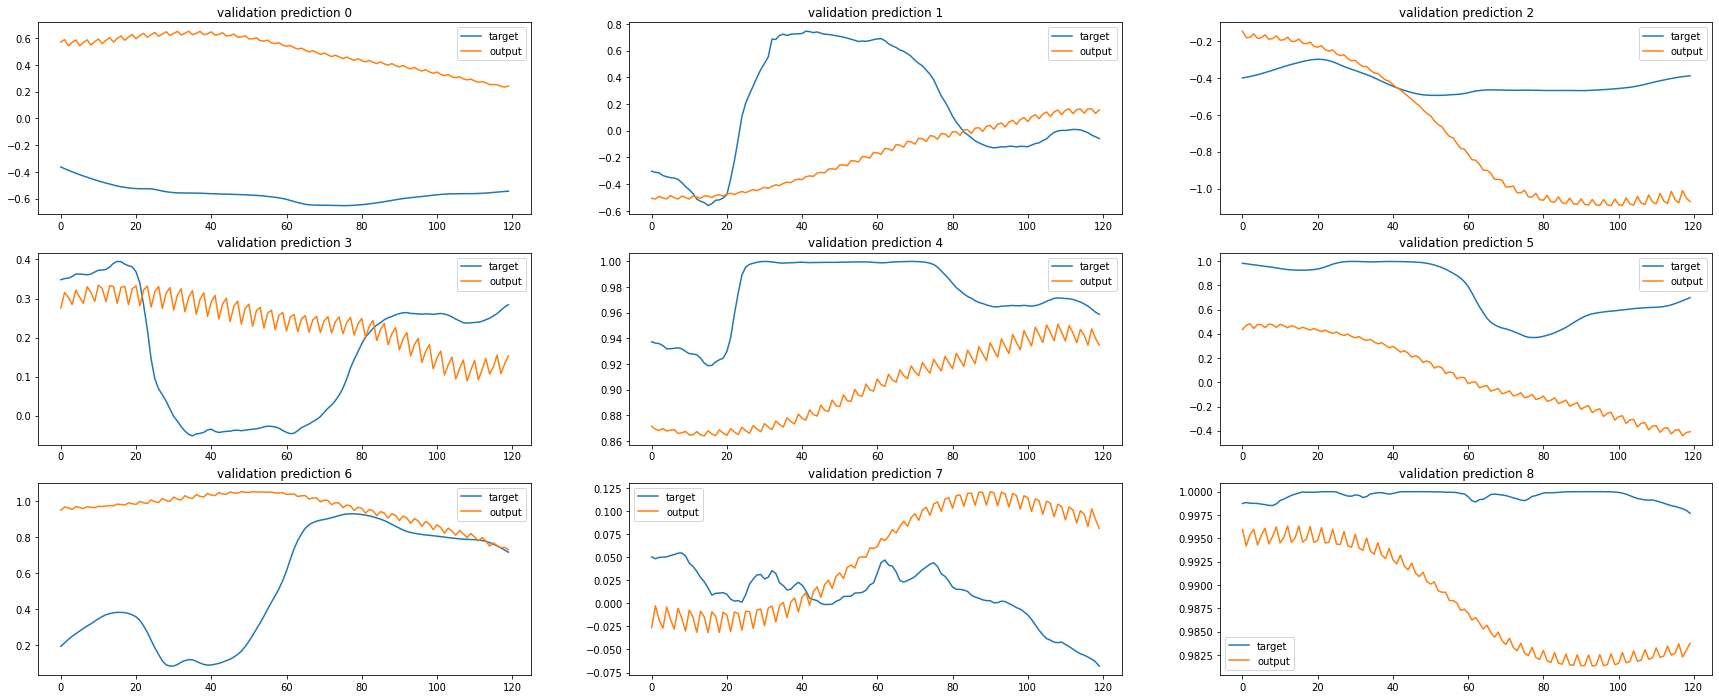

-----------------------------------------------------------------------------------------
| end of epoch  66 | time:  8.55s | valid loss 10.5590 | mean loss   1.0094
-----------------------------------------------------------------------------------------


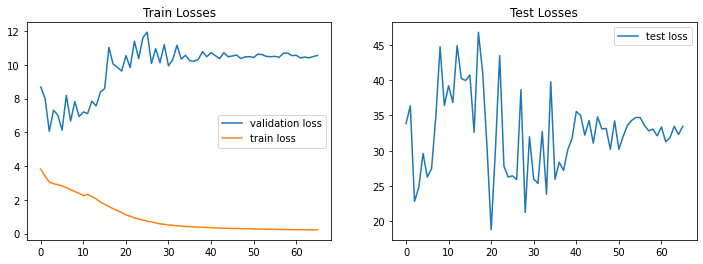

Epoch #67


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  67 |    31/  158 batches | lr 0.00169 | ms/batch 46.89456 | loss 0.20483
| epoch  67 |    62/  158 batches | lr 0.00169 | ms/batch 45.10746 | loss 0.24260
| epoch  67 |    93/  158 batches | lr 0.00169 | ms/batch 44.57878 | loss 0.21975
| epoch  67 |   124/  158 batches | lr 0.00169 | ms/batch 44.77934 | loss 0.20062
| epoch  67 |   155/  158 batches | lr 0.00169 | ms/batch 44.78616 | loss 0.22702
-----------------------------------------------------------------------------------------
| end of epoch  67 | time:  7.49s | valid loss 10.6704 | mean loss   0.9975
-----------------------------------------------------------------------------------------
Epoch #68


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  68 |    31/  158 batches | lr 0.00161 | ms/batch 46.55115 | loss 0.24450
| epoch  68 |    62/  158 batches | lr 0.00161 | ms/batch 44.99695 | loss 0.19556
| epoch  68 |    93/  158 batches | lr 0.00161 | ms/batch 44.46383 | loss 0.20940
| epoch  68 |   124/  158 batches | lr 0.00161 | ms/batch 44.43100 | loss 0.24599
| epoch  68 |   155/  158 batches | lr 0.00161 | ms/batch 44.81156 | loss 0.20492
-----------------------------------------------------------------------------------------
| end of epoch  68 | time:  7.47s | valid loss 10.5572 | mean loss   0.9861
-----------------------------------------------------------------------------------------
Epoch #69


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  69 |    31/  158 batches | lr 0.00153 | ms/batch 47.25048 | loss 0.20438
| epoch  69 |    62/  158 batches | lr 0.00153 | ms/batch 45.21318 | loss 0.21904
| epoch  69 |    93/  158 batches | lr 0.00153 | ms/batch 44.49497 | loss 0.22236
| epoch  69 |   124/  158 batches | lr 0.00153 | ms/batch 44.53155 | loss 0.21399
| epoch  69 |   155/  158 batches | lr 0.00153 | ms/batch 45.04415 | loss 0.20595
-----------------------------------------------------------------------------------------
| end of epoch  69 | time:  7.51s | valid loss 10.4663 | mean loss   0.9749
-----------------------------------------------------------------------------------------
Epoch #70


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  70 |    31/  158 batches | lr 0.00145 | ms/batch 46.14556 | loss 0.25075
| epoch  70 |    62/  158 batches | lr 0.00145 | ms/batch 44.64958 | loss 0.20960
| epoch  70 |    93/  158 batches | lr 0.00145 | ms/batch 44.73151 | loss 0.18987
| epoch  70 |   124/  158 batches | lr 0.00145 | ms/batch 44.61850 | loss 0.20790
| epoch  70 |   155/  158 batches | lr 0.00145 | ms/batch 44.86458 | loss 0.20794
-----------------------------------------------------------------------------------------
| end of epoch  70 | time:  7.46s | valid loss 10.4816 | mean loss   0.9640
-----------------------------------------------------------------------------------------
Epoch #71


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  71 |    31/  158 batches | lr 0.00138 | ms/batch 46.18382 | loss 0.21204
| epoch  71 |    62/  158 batches | lr 0.00138 | ms/batch 44.89406 | loss 0.18951
| epoch  71 |    93/  158 batches | lr 0.00138 | ms/batch 44.66122 | loss 0.20090
| epoch  71 |   124/  158 batches | lr 0.00138 | ms/batch 44.82265 | loss 0.23924
| epoch  71 |   155/  158 batches | lr 0.00138 | ms/batch 44.98466 | loss 0.21902
validation prediction


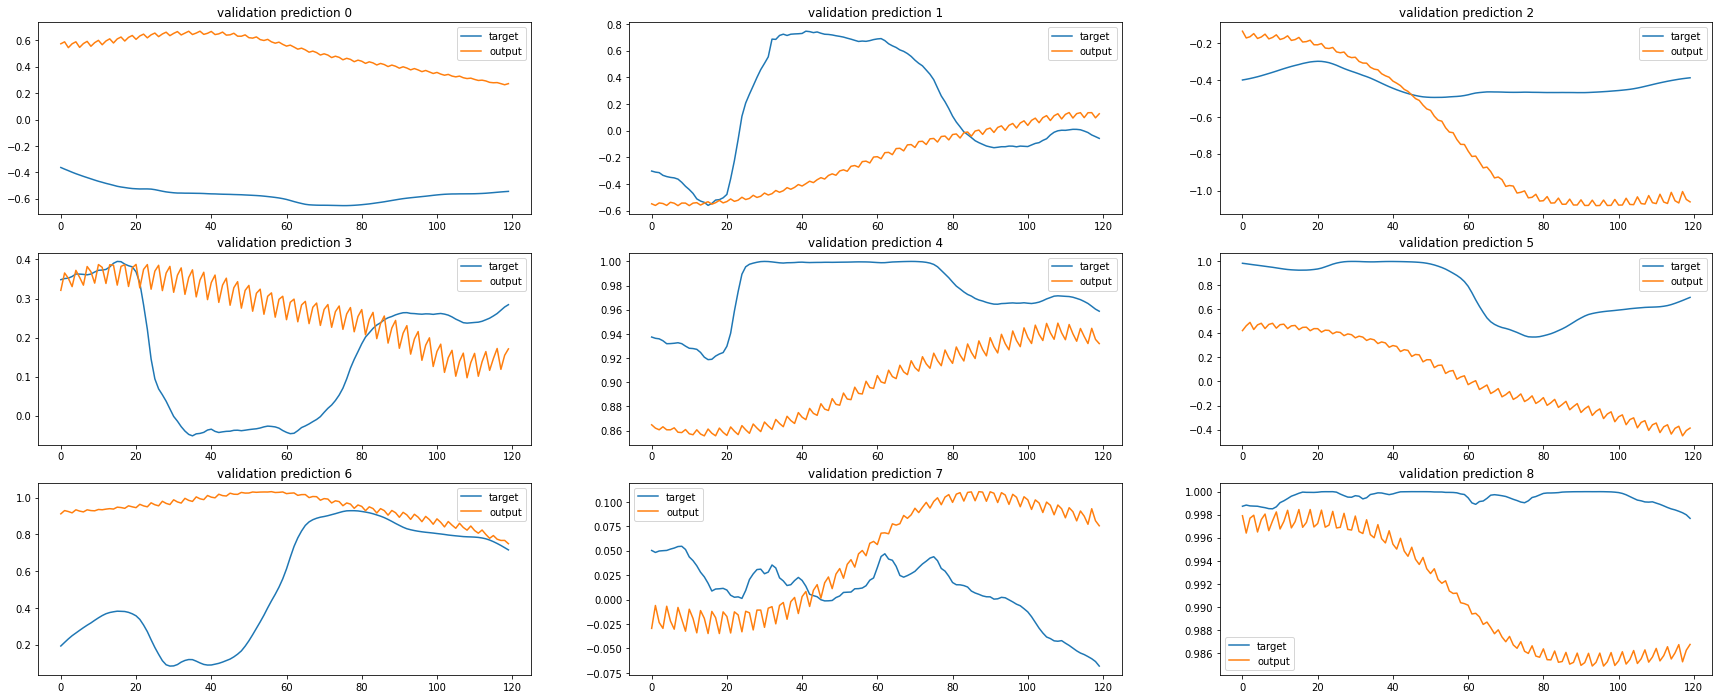

-----------------------------------------------------------------------------------------
| end of epoch  71 | time:  8.58s | valid loss 10.4575 | mean loss   0.9534
-----------------------------------------------------------------------------------------


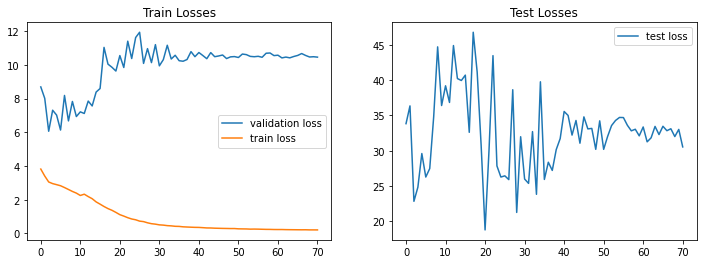

Epoch #72


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  72 |    31/  158 batches | lr 0.00131 | ms/batch 46.20611 | loss 0.22587
| epoch  72 |    62/  158 batches | lr 0.00131 | ms/batch 44.64250 | loss 0.20755
| epoch  72 |    93/  158 batches | lr 0.00131 | ms/batch 44.70287 | loss 0.21935
| epoch  72 |   124/  158 batches | lr 0.00131 | ms/batch 44.85718 | loss 0.19828
| epoch  72 |   155/  158 batches | lr 0.00131 | ms/batch 45.15366 | loss 0.19257
-----------------------------------------------------------------------------------------
| end of epoch  72 | time:  7.47s | valid loss 10.4393 | mean loss   0.9430
-----------------------------------------------------------------------------------------
Epoch #73


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  73 |    31/  158 batches | lr 0.00124 | ms/batch 46.92151 | loss 0.20792
| epoch  73 |    62/  158 batches | lr 0.00124 | ms/batch 44.55861 | loss 0.19409
| epoch  73 |    93/  158 batches | lr 0.00124 | ms/batch 44.58024 | loss 0.18756
| epoch  73 |   124/  158 batches | lr 0.00124 | ms/batch 44.67834 | loss 0.22110
| epoch  73 |   155/  158 batches | lr 0.00124 | ms/batch 45.40968 | loss 0.21977
-----------------------------------------------------------------------------------------
| end of epoch  73 | time:  7.50s | valid loss 10.4708 | mean loss   0.9329
-----------------------------------------------------------------------------------------
Epoch #74


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  74 |    31/  158 batches | lr 0.00118 | ms/batch 47.29181 | loss 0.24568
| epoch  74 |    62/  158 batches | lr 0.00118 | ms/batch 44.87158 | loss 0.19298
| epoch  74 |    93/  158 batches | lr 0.00118 | ms/batch 45.25017 | loss 0.19093
| epoch  74 |   124/  158 batches | lr 0.00118 | ms/batch 45.29210 | loss 0.17485
| epoch  74 |   155/  158 batches | lr 0.00118 | ms/batch 45.80729 | loss 0.20822
-----------------------------------------------------------------------------------------
| end of epoch  74 | time:  7.59s | valid loss 10.4595 | mean loss   0.9230
-----------------------------------------------------------------------------------------
Epoch #75


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  75 |    31/  158 batches | lr 0.00112 | ms/batch 46.11986 | loss 0.20317
| epoch  75 |    62/  158 batches | lr 0.00112 | ms/batch 45.42543 | loss 0.20392
| epoch  75 |    93/  158 batches | lr 0.00112 | ms/batch 44.58530 | loss 0.22434
| epoch  75 |   124/  158 batches | lr 0.00112 | ms/batch 44.89183 | loss 0.18100
| epoch  75 |   155/  158 batches | lr 0.00112 | ms/batch 44.75539 | loss 0.20838
-----------------------------------------------------------------------------------------
| end of epoch  75 | time:  7.49s | valid loss 10.4275 | mean loss   0.9134
-----------------------------------------------------------------------------------------
Epoch #76


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  76 |    31/  158 batches | lr 0.00107 | ms/batch 46.48389 | loss 0.21498
| epoch  76 |    62/  158 batches | lr 0.00107 | ms/batch 44.49694 | loss 0.22532
| epoch  76 |    93/  158 batches | lr 0.00107 | ms/batch 45.12280 | loss 0.22051
| epoch  76 |   124/  158 batches | lr 0.00107 | ms/batch 45.21884 | loss 0.18160
| epoch  76 |   155/  158 batches | lr 0.00107 | ms/batch 44.81689 | loss 0.19178
validation prediction


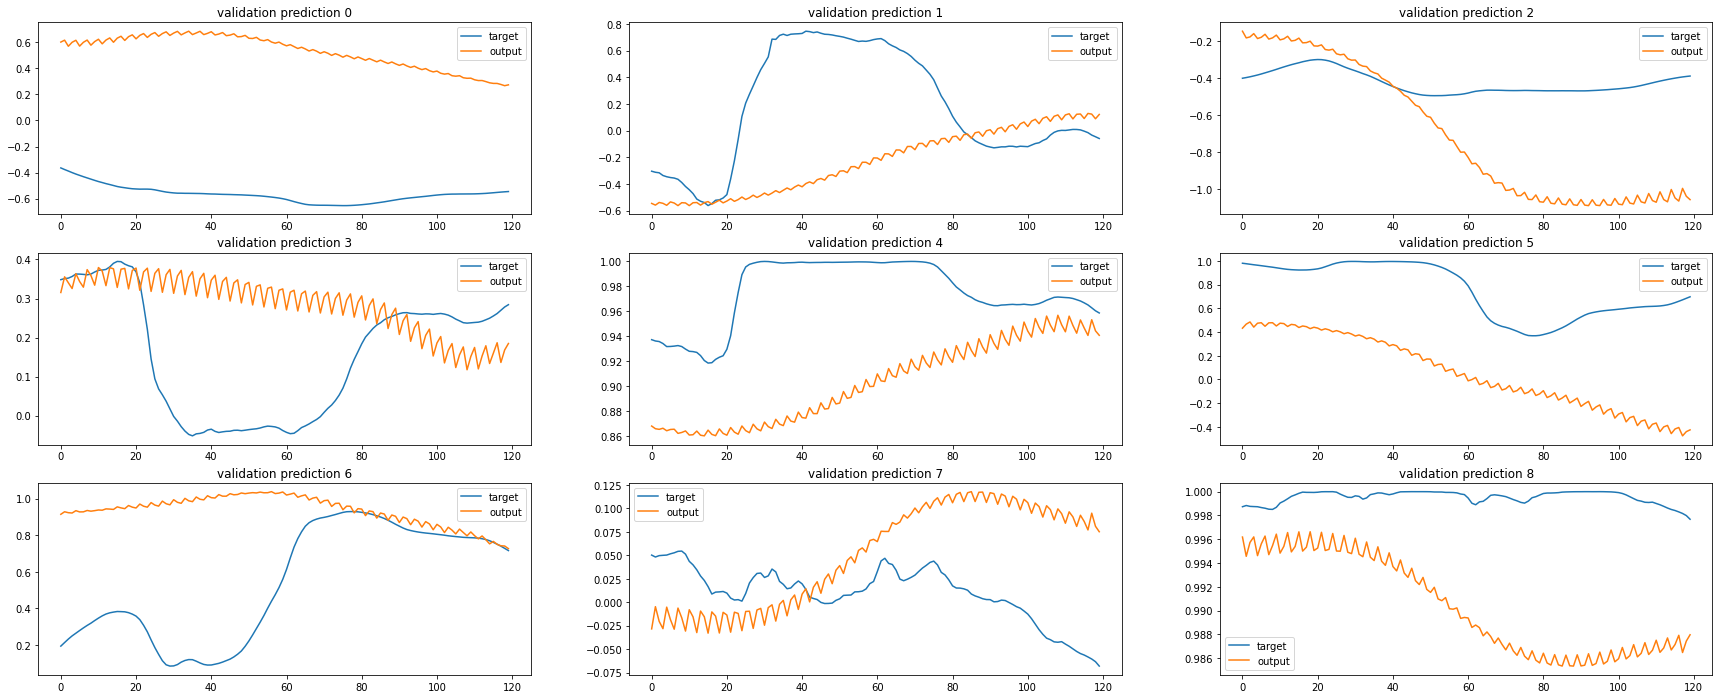

-----------------------------------------------------------------------------------------
| end of epoch  76 | time:  8.49s | valid loss 10.4322 | mean loss   0.9041
-----------------------------------------------------------------------------------------


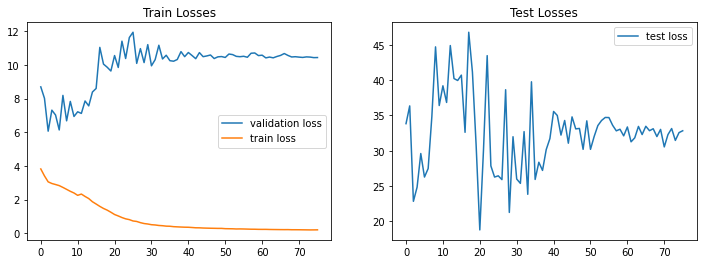

Epoch #77


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  77 |    31/  158 batches | lr 0.00101 | ms/batch 46.34016 | loss 0.19311
| epoch  77 |    62/  158 batches | lr 0.00101 | ms/batch 45.24835 | loss 0.20071
| epoch  77 |    93/  158 batches | lr 0.00101 | ms/batch 45.18793 | loss 0.19123
| epoch  77 |   124/  158 batches | lr 0.00101 | ms/batch 45.45225 | loss 0.18635
| epoch  77 |   155/  158 batches | lr 0.00101 | ms/batch 46.18471 | loss 0.21228
-----------------------------------------------------------------------------------------
| end of epoch  77 | time:  7.56s | valid loss 10.5974 | mean loss   0.8949
-----------------------------------------------------------------------------------------
Epoch #78


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  78 |    31/  158 batches | lr 0.00096 | ms/batch 47.10810 | loss 0.19867
| epoch  78 |    62/  158 batches | lr 0.00096 | ms/batch 44.82204 | loss 0.20357
| epoch  78 |    93/  158 batches | lr 0.00096 | ms/batch 44.60147 | loss 0.20194
| epoch  78 |   124/  158 batches | lr 0.00096 | ms/batch 45.04753 | loss 0.20180
| epoch  78 |   155/  158 batches | lr 0.00096 | ms/batch 44.74455 | loss 0.19432
-----------------------------------------------------------------------------------------
| end of epoch  78 | time:  7.69s | valid loss 10.5203 | mean loss   0.8859
-----------------------------------------------------------------------------------------
Epoch #79


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  79 |    31/  158 batches | lr 0.00091 | ms/batch 47.49240 | loss 0.18497
| epoch  79 |    62/  158 batches | lr 0.00091 | ms/batch 44.69478 | loss 0.20600
| epoch  79 |    93/  158 batches | lr 0.00091 | ms/batch 44.64003 | loss 0.18006
| epoch  79 |   124/  158 batches | lr 0.00091 | ms/batch 44.64380 | loss 0.19681
| epoch  79 |   155/  158 batches | lr 0.00091 | ms/batch 46.35072 | loss 0.22461
-----------------------------------------------------------------------------------------
| end of epoch  79 | time:  7.55s | valid loss 10.5439 | mean loss   0.8772
-----------------------------------------------------------------------------------------
Epoch #80


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  80 |    31/  158 batches | lr 0.00087 | ms/batch 47.09509 | loss 0.19198
| epoch  80 |    62/  158 batches | lr 0.00087 | ms/batch 45.94034 | loss 0.18958
| epoch  80 |    93/  158 batches | lr 0.00087 | ms/batch 45.74895 | loss 0.20287
| epoch  80 |   124/  158 batches | lr 0.00087 | ms/batch 45.14928 | loss 0.19409
| epoch  80 |   155/  158 batches | lr 0.00087 | ms/batch 45.39119 | loss 0.20067
-----------------------------------------------------------------------------------------
| end of epoch  80 | time:  7.59s | valid loss 10.5713 | mean loss   0.8687
-----------------------------------------------------------------------------------------
Epoch #81


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  81 |    31/  158 batches | lr 0.00083 | ms/batch 46.21924 | loss 0.18673
| epoch  81 |    62/  158 batches | lr 0.00083 | ms/batch 44.70478 | loss 0.20508
| epoch  81 |    93/  158 batches | lr 0.00083 | ms/batch 44.93846 | loss 0.21643
| epoch  81 |   124/  158 batches | lr 0.00083 | ms/batch 44.52803 | loss 0.18299
| epoch  81 |   155/  158 batches | lr 0.00083 | ms/batch 44.63457 | loss 0.19148
validation prediction


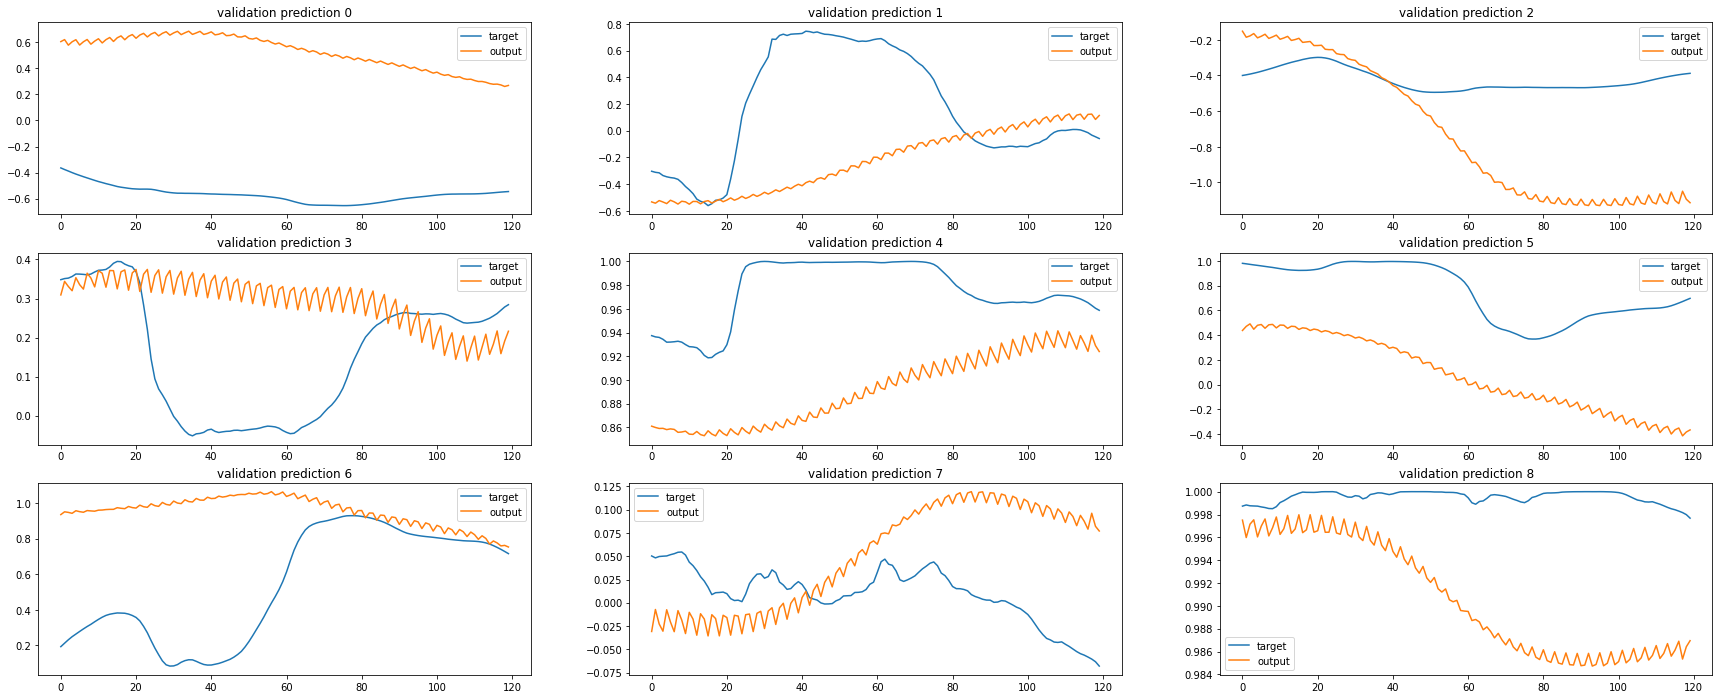

-----------------------------------------------------------------------------------------
| end of epoch  81 | time:  8.59s | valid loss 10.3839 | mean loss   0.8604
-----------------------------------------------------------------------------------------


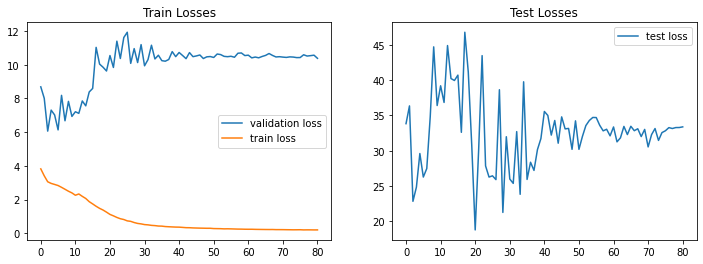

Epoch #82


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  82 |    31/  158 batches | lr 0.00078 | ms/batch 46.19848 | loss 0.21025
| epoch  82 |    62/  158 batches | lr 0.00078 | ms/batch 45.24118 | loss 0.20074
| epoch  82 |    93/  158 batches | lr 0.00078 | ms/batch 45.13215 | loss 0.19799
| epoch  82 |   124/  158 batches | lr 0.00078 | ms/batch 44.45411 | loss 0.17108
| epoch  82 |   155/  158 batches | lr 0.00078 | ms/batch 45.19436 | loss 0.19417
-----------------------------------------------------------------------------------------
| end of epoch  82 | time:  7.50s | valid loss 10.4723 | mean loss   0.8523
-----------------------------------------------------------------------------------------
Epoch #83


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  83 |    31/  158 batches | lr 0.00075 | ms/batch 46.76735 | loss 0.20277
| epoch  83 |    62/  158 batches | lr 0.00075 | ms/batch 44.99881 | loss 0.18338
| epoch  83 |    93/  158 batches | lr 0.00075 | ms/batch 45.26949 | loss 0.18766
| epoch  83 |   124/  158 batches | lr 0.00075 | ms/batch 45.94014 | loss 0.21467
| epoch  83 |   155/  158 batches | lr 0.00075 | ms/batch 46.03810 | loss 0.18241
-----------------------------------------------------------------------------------------
| end of epoch  83 | time:  7.60s | valid loss 10.4822 | mean loss   0.8443
-----------------------------------------------------------------------------------------
Epoch #84


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  84 |    31/  158 batches | lr 0.00071 | ms/batch 46.40018 | loss 0.18429
| epoch  84 |    62/  158 batches | lr 0.00071 | ms/batch 44.75774 | loss 0.19631
| epoch  84 |    93/  158 batches | lr 0.00071 | ms/batch 44.63023 | loss 0.20775
| epoch  84 |   124/  158 batches | lr 0.00071 | ms/batch 44.93427 | loss 0.17578
| epoch  84 |   155/  158 batches | lr 0.00071 | ms/batch 45.81529 | loss 0.19833
-----------------------------------------------------------------------------------------
| end of epoch  84 | time:  7.53s | valid loss 10.5347 | mean loss   0.8365
-----------------------------------------------------------------------------------------
Epoch #85


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  85 |    31/  158 batches | lr 0.00067 | ms/batch 46.51613 | loss 0.20456
| epoch  85 |    62/  158 batches | lr 0.00067 | ms/batch 46.22419 | loss 0.18914
| epoch  85 |    93/  158 batches | lr 0.00067 | ms/batch 44.65747 | loss 0.18940
| epoch  85 |   124/  158 batches | lr 0.00067 | ms/batch 45.71342 | loss 0.18119
| epoch  85 |   155/  158 batches | lr 0.00067 | ms/batch 44.48891 | loss 0.19835
-----------------------------------------------------------------------------------------
| end of epoch  85 | time:  7.55s | valid loss 10.4028 | mean loss   0.8289
-----------------------------------------------------------------------------------------
Epoch #86


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  86 |    31/  158 batches | lr 0.00064 | ms/batch 46.15861 | loss 0.18950
| epoch  86 |    62/  158 batches | lr 0.00064 | ms/batch 45.08277 | loss 0.18197
| epoch  86 |    93/  158 batches | lr 0.00064 | ms/batch 44.73067 | loss 0.18340
| epoch  86 |   124/  158 batches | lr 0.00064 | ms/batch 44.46227 | loss 0.21227
| epoch  86 |   155/  158 batches | lr 0.00064 | ms/batch 44.70167 | loss 0.18300
validation prediction


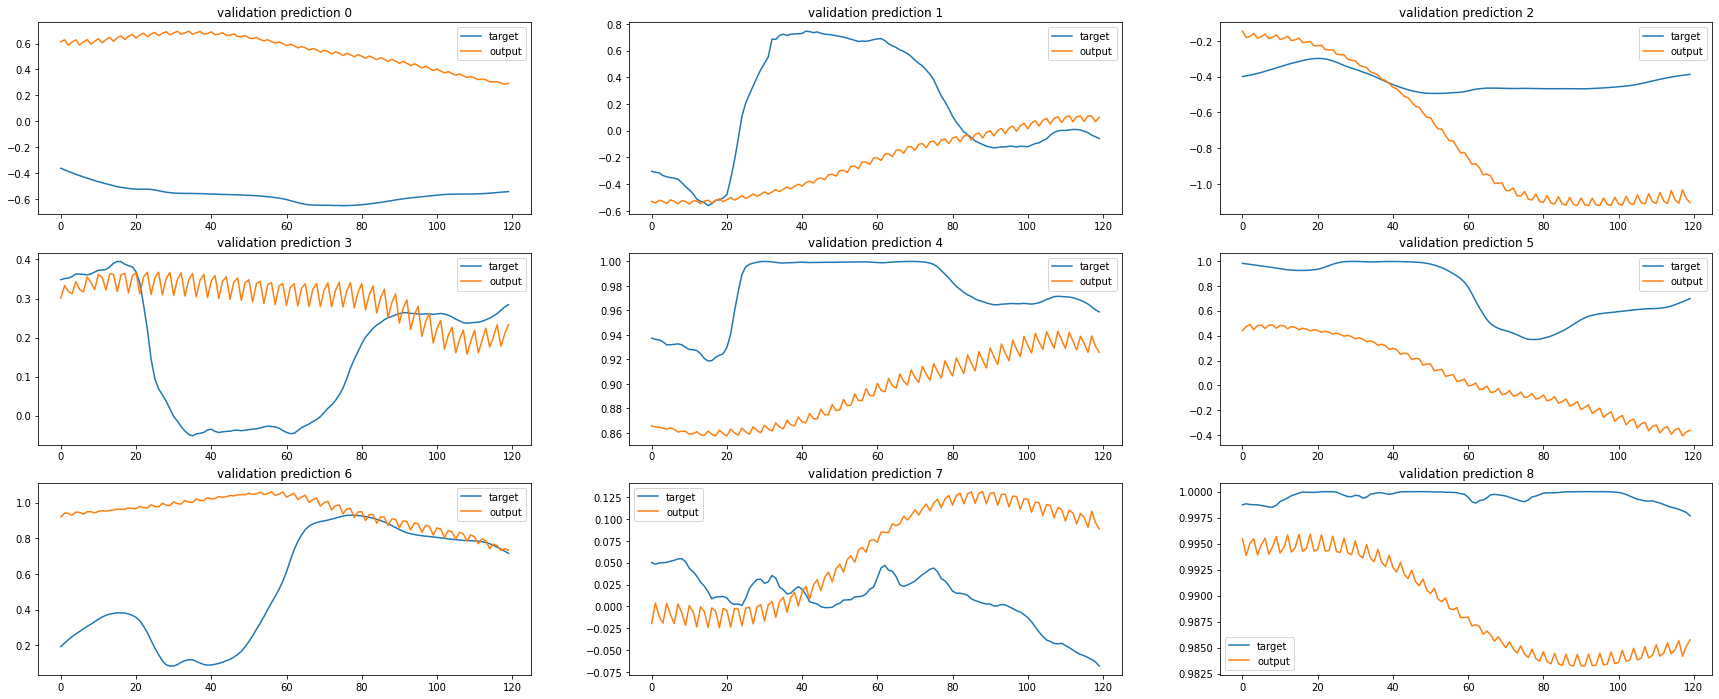

-----------------------------------------------------------------------------------------
| end of epoch  86 | time:  8.45s | valid loss 10.4912 | mean loss   0.8215
-----------------------------------------------------------------------------------------


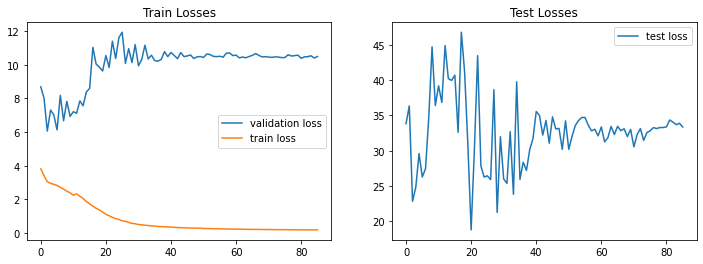

Epoch #87


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  87 |    31/  158 batches | lr 0.00061 | ms/batch 46.11814 | loss 0.18105
| epoch  87 |    62/  158 batches | lr 0.00061 | ms/batch 44.77745 | loss 0.19274
| epoch  87 |    93/  158 batches | lr 0.00061 | ms/batch 44.51120 | loss 0.18615
| epoch  87 |   124/  158 batches | lr 0.00061 | ms/batch 44.69722 | loss 0.18221
| epoch  87 |   155/  158 batches | lr 0.00061 | ms/batch 45.63752 | loss 0.18796
-----------------------------------------------------------------------------------------
| end of epoch  87 | time:  7.48s | valid loss 10.4508 | mean loss   0.8142
-----------------------------------------------------------------------------------------
Epoch #88


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  88 |    31/  158 batches | lr 0.00058 | ms/batch 46.16924 | loss 0.20547
| epoch  88 |    62/  158 batches | lr 0.00058 | ms/batch 44.59352 | loss 0.18228
| epoch  88 |    93/  158 batches | lr 0.00058 | ms/batch 44.67563 | loss 0.19227
| epoch  88 |   124/  158 batches | lr 0.00058 | ms/batch 44.84922 | loss 0.18105
| epoch  88 |   155/  158 batches | lr 0.00058 | ms/batch 45.31973 | loss 0.19334
-----------------------------------------------------------------------------------------
| end of epoch  88 | time:  7.48s | valid loss 10.5052 | mean loss   0.8071
-----------------------------------------------------------------------------------------
Epoch #89


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  89 |    31/  158 batches | lr 0.00055 | ms/batch 46.31879 | loss 0.18579
| epoch  89 |    62/  158 batches | lr 0.00055 | ms/batch 44.65862 | loss 0.18897
| epoch  89 |    93/  158 batches | lr 0.00055 | ms/batch 44.79063 | loss 0.18808
| epoch  89 |   124/  158 batches | lr 0.00055 | ms/batch 45.41006 | loss 0.18600
| epoch  89 |   155/  158 batches | lr 0.00055 | ms/batch 44.88163 | loss 0.19490
-----------------------------------------------------------------------------------------
| end of epoch  89 | time:  7.50s | valid loss 10.4301 | mean loss   0.8001
-----------------------------------------------------------------------------------------
Epoch #90


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  90 |    31/  158 batches | lr 0.00052 | ms/batch 46.39231 | loss 0.17853
| epoch  90 |    62/  158 batches | lr 0.00052 | ms/batch 44.58677 | loss 0.17751
| epoch  90 |    93/  158 batches | lr 0.00052 | ms/batch 44.56625 | loss 0.19689
| epoch  90 |   124/  158 batches | lr 0.00052 | ms/batch 45.50165 | loss 0.19008
| epoch  90 |   155/  158 batches | lr 0.00052 | ms/batch 44.65390 | loss 0.18445
-----------------------------------------------------------------------------------------
| end of epoch  90 | time:  7.50s | valid loss 10.4739 | mean loss   0.7933
-----------------------------------------------------------------------------------------
Epoch #91


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  91 |    31/  158 batches | lr 0.00049 | ms/batch 46.13403 | loss 0.19277
| epoch  91 |    62/  158 batches | lr 0.00049 | ms/batch 44.76015 | loss 0.17752
| epoch  91 |    93/  158 batches | lr 0.00049 | ms/batch 44.72853 | loss 0.17516
| epoch  91 |   124/  158 batches | lr 0.00049 | ms/batch 44.57860 | loss 0.18166
| epoch  91 |   155/  158 batches | lr 0.00049 | ms/batch 44.61159 | loss 0.22574
validation prediction


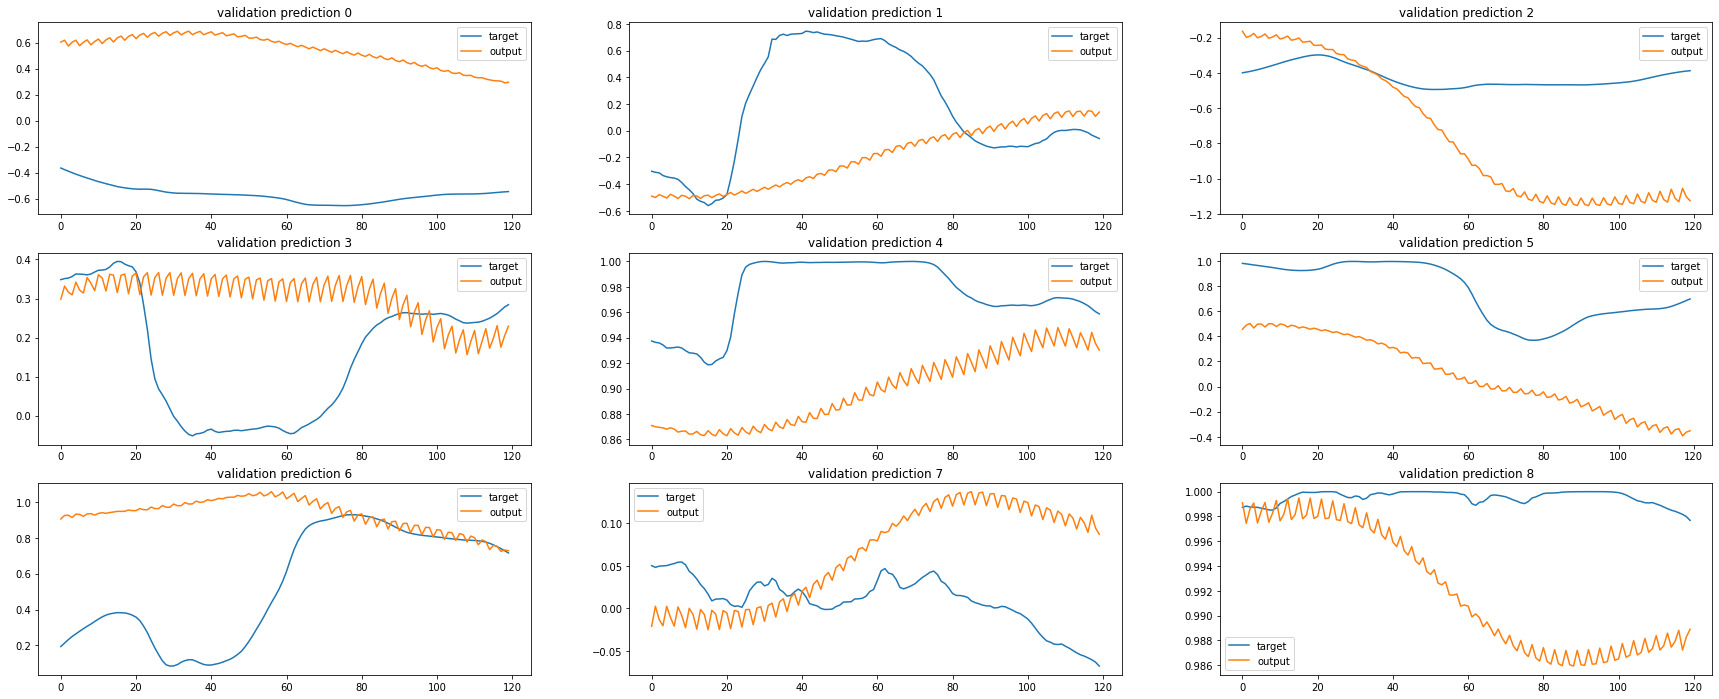

-----------------------------------------------------------------------------------------
| end of epoch  91 | time:  8.56s | valid loss 10.5375 | mean loss   0.7866
-----------------------------------------------------------------------------------------


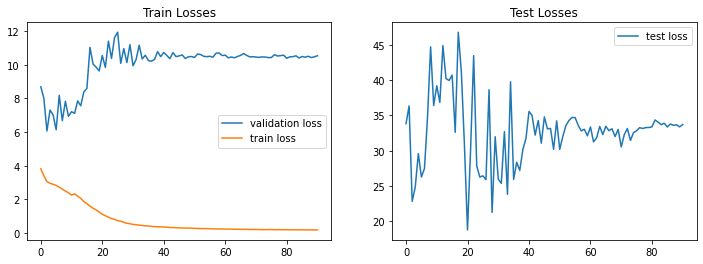

Epoch #92


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  92 |    31/  158 batches | lr 0.00047 | ms/batch 46.23852 | loss 0.18653
| epoch  92 |    62/  158 batches | lr 0.00047 | ms/batch 44.74726 | loss 0.17729
| epoch  92 |    93/  158 batches | lr 0.00047 | ms/batch 44.69054 | loss 0.18363
| epoch  92 |   124/  158 batches | lr 0.00047 | ms/batch 44.70638 | loss 0.18824
| epoch  92 |   155/  158 batches | lr 0.00047 | ms/batch 44.97284 | loss 0.19179
-----------------------------------------------------------------------------------------
| end of epoch  92 | time:  7.48s | valid loss 10.4365 | mean loss   0.7801
-----------------------------------------------------------------------------------------
Epoch #93


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  93 |    31/  158 batches | lr 0.00045 | ms/batch 46.94766 | loss 0.19644
| epoch  93 |    62/  158 batches | lr 0.00045 | ms/batch 44.76949 | loss 0.18109
| epoch  93 |    93/  158 batches | lr 0.00045 | ms/batch 44.82078 | loss 0.19401
| epoch  93 |   124/  158 batches | lr 0.00045 | ms/batch 44.58748 | loss 0.17713
| epoch  93 |   155/  158 batches | lr 0.00045 | ms/batch 44.81325 | loss 0.18848
-----------------------------------------------------------------------------------------
| end of epoch  93 | time:  7.52s | valid loss 10.5287 | mean loss   0.7737
-----------------------------------------------------------------------------------------
Epoch #94


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  94 |    31/  158 batches | lr 0.00042 | ms/batch 46.40127 | loss 0.18325
| epoch  94 |    62/  158 batches | lr 0.00042 | ms/batch 44.91642 | loss 0.20691
| epoch  94 |    93/  158 batches | lr 0.00042 | ms/batch 49.88047 | loss 0.17841
| epoch  94 |   124/  158 batches | lr 0.00042 | ms/batch 44.65825 | loss 0.17886
| epoch  94 |   155/  158 batches | lr 0.00042 | ms/batch 44.56071 | loss 0.17721
-----------------------------------------------------------------------------------------
| end of epoch  94 | time:  7.66s | valid loss 10.4926 | mean loss   0.7674
-----------------------------------------------------------------------------------------
Epoch #95


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  95 |    31/  158 batches | lr 0.00040 | ms/batch 47.97173 | loss 0.17997
| epoch  95 |    62/  158 batches | lr 0.00040 | ms/batch 45.00231 | loss 0.19094
| epoch  95 |    93/  158 batches | lr 0.00040 | ms/batch 44.51553 | loss 0.19533
| epoch  95 |   124/  158 batches | lr 0.00040 | ms/batch 44.64732 | loss 0.17897
| epoch  95 |   155/  158 batches | lr 0.00040 | ms/batch 44.52416 | loss 0.17774
-----------------------------------------------------------------------------------------
| end of epoch  95 | time:  7.53s | valid loss 10.4654 | mean loss   0.7613
-----------------------------------------------------------------------------------------
Epoch #96


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  96 |    31/  158 batches | lr 0.00038 | ms/batch 46.33897 | loss 0.17598
| epoch  96 |    62/  158 batches | lr 0.00038 | ms/batch 45.00367 | loss 0.17677
| epoch  96 |    93/  158 batches | lr 0.00038 | ms/batch 44.66198 | loss 0.21467
| epoch  96 |   124/  158 batches | lr 0.00038 | ms/batch 44.79651 | loss 0.17660
| epoch  96 |   155/  158 batches | lr 0.00038 | ms/batch 45.19343 | loss 0.17993
validation prediction


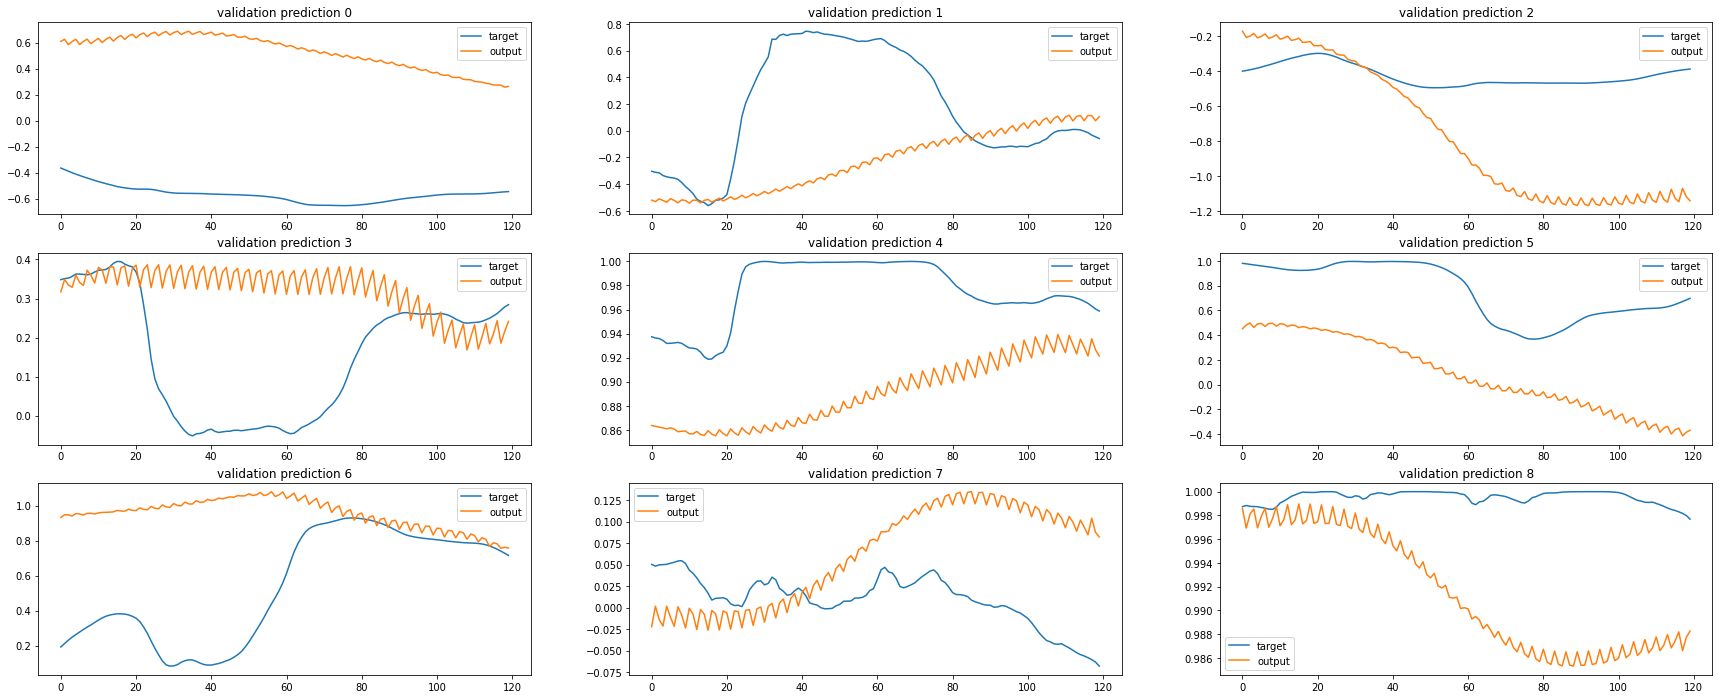

-----------------------------------------------------------------------------------------
| end of epoch  96 | time:  8.49s | valid loss 10.4644 | mean loss   0.7553
-----------------------------------------------------------------------------------------


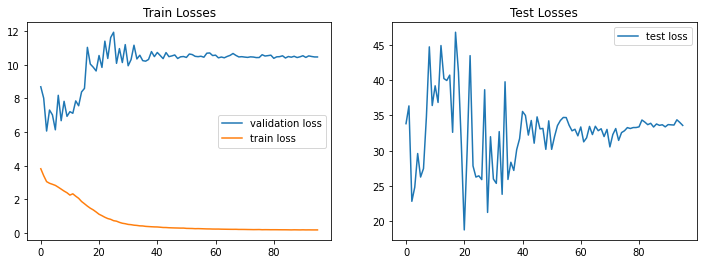

Epoch #97


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  97 |    31/  158 batches | lr 0.00036 | ms/batch 46.27539 | loss 0.17280
| epoch  97 |    62/  158 batches | lr 0.00036 | ms/batch 45.29492 | loss 0.16865
| epoch  97 |    93/  158 batches | lr 0.00036 | ms/batch 44.42886 | loss 0.19489
| epoch  97 |   124/  158 batches | lr 0.00036 | ms/batch 45.45700 | loss 0.19440
| epoch  97 |   155/  158 batches | lr 0.00036 | ms/batch 44.76541 | loss 0.18771
-----------------------------------------------------------------------------------------
| end of epoch  97 | time:  7.50s | valid loss 10.4246 | mean loss   0.7493
-----------------------------------------------------------------------------------------
Epoch #98


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  98 |    31/  158 batches | lr 0.00035 | ms/batch 47.59805 | loss 0.18186
| epoch  98 |    62/  158 batches | lr 0.00035 | ms/batch 46.52424 | loss 0.19913
| epoch  98 |    93/  158 batches | lr 0.00035 | ms/batch 44.59108 | loss 0.18526
| epoch  98 |   124/  158 batches | lr 0.00035 | ms/batch 44.77498 | loss 0.17856
| epoch  98 |   155/  158 batches | lr 0.00035 | ms/batch 45.67352 | loss 0.17161
-----------------------------------------------------------------------------------------
| end of epoch  98 | time:  7.60s | valid loss 10.5023 | mean loss   0.7436
-----------------------------------------------------------------------------------------
Epoch #99


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch  99 |    31/  158 batches | lr 0.00033 | ms/batch 46.02675 | loss 0.17803
| epoch  99 |    62/  158 batches | lr 0.00033 | ms/batch 44.64704 | loss 0.16618
| epoch  99 |    93/  158 batches | lr 0.00033 | ms/batch 44.50606 | loss 0.18102
| epoch  99 |   124/  158 batches | lr 0.00033 | ms/batch 45.42474 | loss 0.20786
| epoch  99 |   155/  158 batches | lr 0.00033 | ms/batch 44.87684 | loss 0.18760
-----------------------------------------------------------------------------------------
| end of epoch  99 | time:  7.50s | valid loss 10.4451 | mean loss   0.7379
-----------------------------------------------------------------------------------------
Epoch #100


  0%|          | 0/158 [00:00<?, ?it/s]

| epoch 100 |    31/  158 batches | lr 0.00031 | ms/batch 46.48028 | loss 0.18571
| epoch 100 |    62/  158 batches | lr 0.00031 | ms/batch 44.77644 | loss 0.16802
| epoch 100 |    93/  158 batches | lr 0.00031 | ms/batch 44.70443 | loss 0.18201
| epoch 100 |   124/  158 batches | lr 0.00031 | ms/batch 44.56761 | loss 0.17362
| epoch 100 |   155/  158 batches | lr 0.00031 | ms/batch 44.56688 | loss 0.22194
-----------------------------------------------------------------------------------------
| end of epoch 100 | time:  7.47s | valid loss 10.5026 | mean loss   0.7324
-----------------------------------------------------------------------------------------


In [17]:
# Trainig
#build live matplotlib fig


#plt.ion()
#fig.show()
#fig.canvas.draw()

LOAD_MODEL = False
if LOAD_MODEL:
    load_ckpt("{}/checkpoints/epoch_{}_batch_{}_ckpts.pt".format(os.getcwd(), 50, batch_size), model, optimizer)
lr = 0.1
scaler = torch.cuda.amp.GradScaler()
print(scaler)
best_val_loss = float('inf')
#writer = SummaryWriter("run/loss_plot")
step = 0

epochs = 100
for epoch in tqdm(range(1, epochs+1)):
    print(f'Epoch #{epoch}')
    epoch_start_time = time.time()
    train_loss, sep_train_loss, train_pearsonr = train(model, train_dataloader, optimizer, scaler, None, step)
#     print(train_loss)
    train_losses.append(train_loss)
    sep_train_losses.append(sep_train_loss)
    mean_loss = sum(train_losses)/len(train_losses)
    val_loss, sep_val_loss, val_pearsonr = validate(model, val_dataloader,plot_flag=True if epoch % 5 == 1 else False)
    val_losses.append(val_loss)
    sep_val_losses.append(sep_val_loss)
    test_loss, sep_test_loss, test_pearsonr = validate(model, test_dataloader)
    test_losses.append(test_loss)
    sep_test_losses.append(sep_test_loss)
    elapsed = time.time() - epoch_start_time
    print('-' * 89)
    print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
        f'valid loss {val_loss:5.4f} | mean loss {mean_loss:8.4f}')
    print('-' * 89)
    if epoch % 5 == 1:
        fig, ax = plt.subplots(1,2, figsize=(12,4))
        #ax.plot([i.detach().cpu().numpy() for i in test_losses], label='train loss')
        ax[0].plot([i.detach().cpu().numpy() for i in val_losses ] , label='validation loss')
        ax[0].plot([i  for i in train_losses ] , label='train loss')
        ax[0].set_title("Train Losses")

        ax[0].legend()
        ax[1].plot([i.detach().cpu().numpy() for i in test_losses], label='test loss')
        ax[1].set_title("Test Losses")
        ax[1].legend()
        #fig.canvas.draw()
        plt.show()
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # save model
#         save_ckpt("{}/checkpoints/epoch_{}_ckpts.pt".format(os.getcwd(), epoch), model, optimizer,epochs, val_loss)
        #save_ckpt("{}/checkpoints".format(os.getcwd(), epoch), model, optimizer,epochs, train_losses, val_losses)

    # scheduler.step(mean_loss)
    scheduler.step()
# load_ckpt("/content/drive/MyDrive/checkpoints.pt", model, optimizer)
